# **Group 7 Final Term - Event Based Backtester**
**Contributors:**
- Brandon Lau Ming Jun
- Cheang Chi Yan Anthony
- Mehak A Sharma
- Ong Chang Hui
- Soh Kian Hao Justin

---
### **Overview**
In this project, we aim to develop an event based backtester that runs a trading strategy based on the Coppock Curve and VIX. Before we begin, we will do a screening of our stocks, then build our backtesting classes. Subsequently we will tune our strategy's parameters on daily data from 2010 to 2016 before testing them during the required time period of 01/01/2017 - 31/12/2019.

---

### **Strategy Description**
We opted to use the Coppock Curve, which is a momentum indicator used primarily to identify long-term buying opportunities in the stock market. Our strategy combines the Coppock Curve with the VIX indicator for confirmation. VIX would reduce the number of signals generated, but would allow us to trade with higher confidence. Our strategy introduces daily rebalancing to constantly determine the optimal capital distribution.

---

### **Trade Signal**

Buy and sell signals are grounded in a dual-indicator approach. We will next explain these signals using our dynamic weight allocation mechanism, PositionOptima.

1. **Buy Signal**:  
   When the **Coppock Curve crosses above zero** (> 0): interpreted as a sign of upward momentum, signaling a potential **buy** opportunity.
   
   - **VIX Confirmation**:
    - If the **VIX** value is **below** a predefined threshold, it indicates a less volatile market. As such, we gain optimism by **increasing the weight** of a long position.
    - If the **VIX** value is **above** a predefined threshold, a highly volatile market is to be expected. We remain cautiously optimistic by maintaining a long position with a **base weight**.

2. **Sell Signal**:  
   When the **Coppock Curve crosses below or at zero** (≤ 0): interpreted as a sign of downward momentum, signaling a potential **sell** opportunity.

   - **VIX Confirmation**:
    - If the **VIX** value is **above** a predefined threshold, a highly volatile market is to be expected. As the trend may reverse, we take a **small short position**.
    - If the **VIX** value is **below** a predefined threshold, we deem market volatility to have settled. As such, we maintain a long position with a **base weight**
    

## **Initial Imports**

---
In this section, we will import the necessary libraries. We will use the `yfinance` library to pull historical price data for the backtest period.

In [ ]:
# # Install all important libraries
# !pip install yfinance
# !pip install ta


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing all necessary libraries for technical analysis, data manipulation, and visualization

# Data Manipulation
# Importing Numpy for efficient array operations and mathematical functions
import numpy as np
# Importing Pandas for handling and analyzing data in DataFrames
import pandas as pd

# Data Visualization
# Importing Matplotlib for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Financial Data Retrieval
# Importing yfinance to download stock and financial data
import yfinance as yf

# Technical Indicators
# Importing Rate of Change (ROC) for momentum-based analysis
from ta.momentum import roc
# Importing Weighted Moving Average (WMA) for trend analysis
from ta.trend import WMAIndicator

# Multiprocessing and Parallel Processing
# Importing ThreadPoolExecutor for managing concurrent threads
from concurrent.futures import ThreadPoolExecutor, as_completed

# Importing itertools for efficient looping and data manipulation functions
import itertools

# Warnings Control
# Importing warnings library to manage and filter deprecation warnings
import warnings
# Suppressing all warnings to reduce console clutter
warnings.filterwarnings("ignore")

## **Stock Screening**
---

Stocks from multiple sectors would first be screened via a systematic approach. We then perform a numerical analysis before plotting a correlation matrix for stock returns.

### Criteria
The following are our criteria to ensure robustness in the testing of our strategy
#### 1. Data Availability
Choose stocks with complete historical data to ensure robustness of backtesting. Large cap stocks would be selected due to availability of reliable data.

#### 2. Sector Representation
Stocks from different sectors respond differently to market volatility and changes in macroeconomic conditions. Having a mix of sectors ensures our strategy is tested across different market conditions (bull, bear or sideways). We also aim to avoid overfitting with a selection diversified range of stocks.

#### 3. Dollar Volume Requirement
Stocks would be required to have an average dollar volume of more than $100 million. Dollar volume is calculated by multiplying the price of a share by the number of shares traded. We aim for stocks with a high dollar volume to ensure high liquidity and to minimise the impact of bid-ask spreads. This requirement also ensures the avoidance of penny stocks, a form of risk management that ensure the strategy only invests in stocks that are less prone to manipulation and speculation.

#### 4. Beta Requirements
Stocks with a variety of beta would be selected. This allows the team to better understand and evaluate the performance of the strategy under different market conditions.

We will next perform stock screening on stocks from five sectors that match our criteria listed above.

### Helper Functions  

In [3]:
def stock_screening(us_stocks, start_date='2010-01-01', end_date='2016-12-31'):
    """Select stocks for backtesting based on specific criteria

    Parameters:
    -----------
    tickers (list): List of stock ticker symbols
    start_date (str): Start date for analysis in 'YYYY-MM-DD' format
    end_date (str): End date for analysis in 'YYYY-MM-DD' format
    risk_free_rate (float): Annual risk-free rate (default: 0%)

    Returns:
    dataframe -- Financial metrics for each stock, including the Sharpe ratio and other metrics.
    """

    selected_stocks = []

    # Loop through each stock ticker in the provided list
    for ticker in us_stocks:
        try:
            # Download historical data for the stock
            stock_data = yf.Ticker(ticker)
            stock = stock_data.history(start=start_date, end=end_date)

            # Check if data exists for the stock
            if len(stock) > 0:
                # Define selection criteria:
                # 1. Compute average daily volume
                avg_volume = stock['Volume'].mean()

                # 2. Compute average price
                avg_price = stock['Close'].mean()

                # 3. Compute average dollar volume from price and volume
                avg_dollar_volume =  avg_price * avg_volume


                # Append stocks meeting all criteria to selected_stocks
                if (avg_dollar_volume > 100000000):

                    selected_stocks.append({
                        'Ticker': ticker,
                        'Name' : stock_data.info.get('shortName', 'Unknown'),   # Stock name from Yahoo Finance info
                        'Sector': stock_data.info.get('sector', 'Unknown'),     # Stock sector from Yahoo Finance info
                        'Avg Price': avg_price,                                 # Average stock price over the period
                        'Avg Volume': avg_volume,                               # Average trading volume
                        'Dollar Volume': avg_dollar_volume,                     # Dollar volume traded
                    })
                else:
                    # Print reason for skipping stocks that don't meet criteria
                    print(f"Skipping {ticker} due to criteria. Dollar Volume {avg_dollar_volume}")

        except Exception as e:
            # Handle and log any errors in data retrieval or processing
            # Filters stocks that do not have complete historical data
            print(f"Error processing {ticker}: {str(e)}")

    df = pd.DataFrame(selected_stocks)
    
    # Format values for readability
    pd.options.display.float_format = '{:,.2f}'.format
    df.index = df.index + 1

    # Return a DataFrame containing all selected stocks and their attributes
    return df


def calculate_metrics(ticker, benchmark='^GSPC', start_date='2010-01-01', end_date ='2016-12-31', risk_free_rate=0.00):
    """
    Calculate alpha, beta, Sharpe ratio, and other performance metrics for a given stock or portfolio.

    Parameters:
    -----------
    ticker (str): Stock ticker symbol
    benchmark (str): Benchmark ticker symbol (default is S&P 500)
    start_date (str): Start date for analysis in 'YYYY-MM-DD' format
    end_date (str): End date for analysis in 'YYYY-MM-DD' format
    risk_free_rate (float): Annual risk-free rate (default is 0%)

    Returns:
    dict -- Financial metrics, including the Sharpe ratio and other metrics.
    """

    # Download data for the stock and benchmark within the date range
    ticker_data = yf.Ticker(ticker)
    market_ticker_data = yf.Ticker(benchmark)
    stock = ticker_data.history(start=start_date, end=end_date)['Close']
    market = market_ticker_data.history(start=start_date, end=end_date)['Close']

    # Calculate daily percentage returns for the stock and the benchmark
    stock_returns = stock.pct_change().dropna()
    market_returns = market.pct_change().dropna()

    # Align the stock and market data into a single DataFrame
    df = pd.concat([stock_returns, market_returns], axis=1)
    df.columns = ['stock', 'market']

    # Calculate beta as the covariance of stock and market returns divided by the variance of market returns
    beta = np.cov(df['stock'], df['market'])[0,1] / np.var(df['market'])

    avg_daily_return = np.mean(df['stock'])
    daily_volatility = np.std(df['stock'])

    # Annualize the average return and volatility
    avg_annual_return = avg_daily_return * 252
    annual_volatility = daily_volatility * np.sqrt(252)

    # Calculate the Sharpe ratio as excess return over annual volatility
    excess_return = avg_annual_return - risk_free_rate
    sharpe_ratio = excess_return / annual_volatility

    # Calculate alpha as the difference between stock return and the market return adjusted for beta
    alpha = avg_annual_return - risk_free_rate - (beta * (np.mean(df['market']) * 252 - risk_free_rate))

    return {
        'Name' : ticker_data.info.get('shortName', 'Unknown'),
        'Sector': ticker_data.info.get('sector', 'Unknown'),
        'Sharpe ratio': sharpe_ratio,
        'Alpha': alpha,
        'Beta': beta,
        'Annual return': avg_annual_return,
        'Annual volatility': annual_volatility,
        'Market return': np.mean(df['market']) * 252,
        'Market volatility': np.std(df['market']) * np.sqrt(252)
    }

def compare_stocks(tickers, start_date='2010-01-01', end_date='2016-12-31', risk_free_rate=0.00):
    """
    Compare multiple stocks based on their risk-adjusted performance metrics.

    Parameters:
    -----------
    tickers (list): List of stock ticker symbols
    start_date (str): Start date for analysis in 'YYYY-MM-DD' format
    end_date (str): End date for analysis in 'YYYY-MM-DD' format
    risk_free_rate (float): Annual risk-free rate (default: 0%)

    Returns:
    DataFrame -- Financial metrics for each stock, including the Sharpe ratio and other metrics.
    """

    # Initialize an empty list to store results for each stock
    results = []
    for ticker in tickers:
        try: 
            # Calculate metrics for each stock in the list
            metrics = calculate_metrics(ticker, start_date=start_date, end_date=end_date, risk_free_rate=risk_free_rate)
            metrics['ticker'] = ticker
            results.append(metrics)
        except Exception as e:
            # Handle any errors encountered during processing
            print(f"Error processing {ticker}: {str(e)}")

    # Convert results into a DataFrame and set 'ticker' as the index
    df_results = pd.DataFrame(results)
    df_results = df_results.set_index('ticker')

    # Sort the DataFrame by sector and Sharpe ratio in descending order
    return df_results

def plot_stock_correlation(tickers, start_date='2010-01-01', end_date='2016-12-31'):
    """
    Plot correlation of stock returns based on list of stock symbols provided

    Parameters:
    -----------
    tickers (list): List of stock ticker symbols
    start_date (str): Start date for analysis in 'YYYY-MM-DD' format
    end_date (str): End date for analysis in 'YYYY-MM-DD' format)

    """

    # Download historical stock data
    stocks = yf.download(tickers, start=start_date, end=end_date)['Close']
    # Calculate the returns
    returns = stocks.pct_change().dropna()

    # Calculate the correlation matrix of returns
    correlation_matrix_returns = returns.corr()

    # Plot the correlation matrix for stock returns
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix_returns, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Stock Returns Correlation Matrix')
    plt.show()

### Stock Screening Outcome

In [4]:
# List of stock tickers categorized by sector for analysis

tickers = [
    # Consumer Cyclical
    'SBUX', 'MCD',
    # Consumer Defensive
    "COST", "PG",
    # Financial Services
    "V", "MA",
    # Healthcare
    "JNJ", "PFE",
    # Technology
    "AAPL", "NVDA",
]


In [5]:
# Selecting stocks that fulfil dollar volume criteria
filtered_df = stock_screening(tickers, start_date="2010-01-01", end_date="2016-12-31")
filtered_df

Ticker                            Name              Sector  Avg Price  \
1    SBUX           Starbucks Corporation   Consumer Cyclical      28.05   
2     MCD          McDonald's Corporation   Consumer Cyclical      70.96   
3    COST    Costco Wholesale Corporation  Consumer Defensive      87.39   
4      PG  Procter & Gamble Company (The)  Consumer Defensive      53.72   
5       V                       Visa Inc.  Financial Services      42.69   
6      MA         Mastercard Incorporated  Financial Services      56.94   
7     JNJ               Johnson & Johnson          Healthcare      62.75   
8     PFE                    Pfizer, Inc.          Healthcare      16.37   
9    AAPL                      Apple Inc.          Technology      17.44   
10   NVDA              NVIDIA Corporation          Technology       0.53   

       Avg Volume    Dollar Volume  
1   12,087,999.60   339,063,711.30  
2    5,971,688.48   423,751,160.01  
3    2,453,564.19   214,413,966.94  
4   10,128,166.06   544,100,293.35  
5   15,174,262.37   647,787,905.35  
6    8,132,908.80   463,064,387.27  
7    9,826,021.51   616,540,474.18  
8   39,204,444.38   641,741,849.93  
9  376,913,793.42 6,573,481,214.56  
10 504,452,286.04   264,999,549.77

Upon stock screening, each of the 10 stocks listed above matches our criteria. They range from 5 different sectors namely Consumer Cyclical. Consumer Defensive, Healthcare, Financial Services, and Technology. Each stock has complete historical data from 2010 to 2016 and a high dollar volume.
We will next compute the financial metrics of the stocks.

In [6]:
# Run the comparison of multiple stocks based on their risk-adjusted performance metrics for a different training period
# This will calculate metrics for each ticker within the specified date range (2010-2016)
train_df = compare_stocks(filtered_df['Ticker'].to_list(), start_date='2010-01-01', end_date='2016-12-31')

# Display the resulting DataFrame containing performance metrics for each stock in the training period
train_df

Name              Sector  Sharpe ratio  \
ticker                                                                     
SBUX             Starbucks Corporation   Consumer Cyclical          1.08   
MCD             McDonald's Corporation   Consumer Cyclical          0.91   
COST      Costco Wholesale Corporation  Consumer Defensive          1.06   
PG      Procter & Gamble Company (The)  Consumer Defensive          0.61   
V                            Visa Inc.  Financial Services          0.88   
MA             Mastercard Incorporated  Financial Services          0.90   
JNJ                  Johnson & Johnson          Healthcare          0.89   
PFE                       Pfizer, Inc.          Healthcare          0.70   
AAPL                        Apple Inc.          Technology          0.91   
NVDA                NVIDIA Corporation          Technology          0.86   

        Alpha  Beta  Annual return  Annual volatility  Market return  \
ticker                                                                 
SBUX     0.16  1.02           0.27               0.25           0.11   
MCD      0.08  0.58           0.14               0.15           0.11   
COST     0.11  0.65           0.18               0.17           0.11   
PG       0.03  0.54           0.09               0.14           0.11   
V        0.11  1.01           0.22               0.25           0.11   
MA       0.11  1.16           0.24               0.27           0.11   
JNJ      0.06  0.62           0.12               0.14           0.11   
PFE      0.04  0.79           0.13               0.19           0.11   
AAPL     0.14  0.94           0.24               0.26           0.11   
NVDA     0.19  1.37           0.34               0.39           0.11   

        Market volatility  
ticker                     
SBUX                 0.16  
MCD                  0.16  
COST                 0.16  
PG                   0.16  
V                    0.16  
MA                   0.16  
JNJ                  0.16  
PFE                  0.16  
AAPL                 0.16  
NVDA                 0.16

[*********************100%***********************]  10 of 10 completed


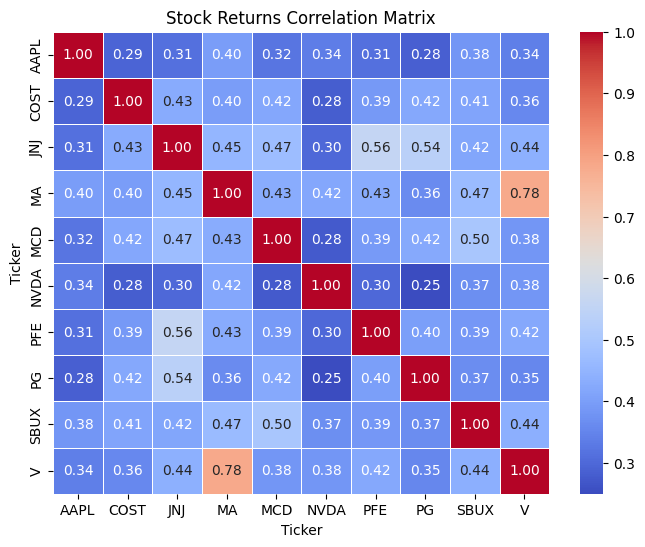

In [7]:
plot_stock_correlation(filtered_df['Ticker'].to_list(), '2010-01-01', '2016-12-31')

Returns of stocks within the same sector show moderate positive correlation of 0.3 to 0.56. The exception would be the returns of V and MA being high correlated at 0.78. However, this is expected as both companies serve as payment providers. Returns of stocks from the different sectors show lower positive correlations.

The correlation matrix shows that our screened stocks generally move together but with sector-specific variations that allow our strategy to be tested against diverse market conditions.

In [8]:
# Define the list of selected sectors for analysis: Consumer Cyclical, Consumer Defensive, Financial Services, Healthcare, and Technology
sectors = list(train_df.Sector.unique())

# For each selected sector, store their indices in the dictionary 'res'
res = {
    sector: train_df.query(f"Sector == @sector").index.tolist() for sector in sectors
}

# Display the dictionary 'res' with the tickers from the top 2 stocks in each selected sector
res

{'Consumer Cyclical': ['SBUX', 'MCD'],
 'Consumer Defensive': ['COST', 'PG'],
 'Financial Services': ['V', 'MA'],
 'Healthcare': ['JNJ', 'PFE'],
 'Technology': ['AAPL', 'NVDA']}

## **Initialise Backtesting Classes**
---
For event based backtesting, an important concept is a bar. A bar is unit of data or information and represents an event. Event based backtesting will be based on new bars coming in, and not on the full dataset.

First, we will build a Common_Class, which will be utilised for common tasks like preparing data, plotting results, placing orders etc.

Subsequently, we will build the CoppockVIX_Strategy class that inherits from Common_Class and contains the logic for our trading strategy. This extends on the CoppockVIX_Strategy class that we have worked on for the assignment, and contains a new hyperparameter_tuning method that will tune our strategy via grid search to optimise on the training data.

Lastly, we will build a HyperparameterTuning class. This class is meant to be a generic class, that takes in a strategy, list of stocks and fixed parameters. This class aims to optimise our strategy at the portfolio level, as we have more than 5 stocks after stock screening, and any combination of 5 stocks would match our investor's risk appetite.

In [9]:
# For event based backtesting, an important concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [10]:
class Common_Class():
    def __init__(self, symbol, benchmark, start, end, interval, capital, transaction_cost, verbose = 2):
        """
        Initializes the backtesting environment for the strategy.

        Parameters:
        -----------
        symbol           -- List of stock symbols for the strategy.
        benchmark        -- A benchmark symbol used to calculate tracking error and information ratio.
        start            -- Start date for the historical data.
        end              -- End date for the historical data.
        interval         -- Time interval for stock data (e.g., '1d' for daily data).
        capital          -- Initial capital for the backtest.
        transaction_cost -- The transaction cost for buying/selling assets.
        verbose          -- Verbosity level for logging (default 2). 0 prints everything. 1 prints results only and 2 prints nothing.
        """

        # Initialize dictionaries for storing stock data, positions, and quantities of stocks
        self.all_data ={}  # Dictionary to store historical stock data for each stock symbol
        self.position = {}  # Dictionary to track the position (long/short) of each stock
        self.quantity = {}  # Dictionary to track the quantity of each stock held

        # Initialize quantity for each stock to zero
        for stock in symbol:
            self.quantity['{}'.format(stock)] = 0

        # Set attributes
        self.symbol = symbol
        self.benchmark = benchmark                  # Benchmark symbol
        self.start = start                          # Start date of the backtest
        self.end = end                              # End date of the backtest
        self.interval = interval                    # Interval for stock data (e.g., daily, hourly)
        self.initial_capital = capital              # The initial capital for backtest
        self.capital = capital                      # Capital is updated after trades
        self.transaction_cost = transaction_cost    # Transaction cost per trade
        self.trades = 0                             # Track the number of trades executed
        self.verbose = verbose                      # Verbosity level for logging
        self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital'])  # DataFrame for storing trade details

        # Prepare the data by downloading stock data and computing returns
        self.prepare_data()

    def prepare_data(self):
        """
        Fetches historical stock data for the provided symbols and benchmark,
        calculates log returns, and stores the data in `self.all_data`.
        """

        # Fetch and process benchmark data first
        hist_stock = yf.Ticker(self.benchmark).history(start=self.start, end=self.end, interval = self.interval)
        bt_data = pd.DataFrame()
        bt_data["Close_Price"] =  hist_stock["Close"]

        # Calculate log returns for the benchmark
        bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data = bt_data.dropna()

        # Store benchmark data
        self.all_data[self.benchmark] = bt_data

        # Fetch and process data for each stock symbol
        for i in self.symbol:
            stock_data = yf.Ticker(i)
            hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_stock["Close"]

            # Calculate log returns for the stock
            bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()

            # Store stock data
            self.all_data['{}'.format(i)] = bt_data

        # Make a copy of original data for resetting purposes
        self.original_all_data = self.all_data.copy()

    def reset(self):
        """
        Resets the backtester to its initial state, allowing for faster hyperparameter tuning.
        Reinitializes stock data, positions, quantities, and capital.
        """

        # Reinitialize dictionaries for stock data, positions, and quantities
        self.all_data = {}  # Stores historical stock data
        self.position = {}  # Tracks positions for each stock
        self.quantity = {}  # Tracks quantity of each stock held

        # Reset quantity for each stock to zero
        for stock in self.symbol:
            self.quantity['{}'.format(stock)] = 0

        # Reset capital and trade count
        self.capital = self.initial_capital
        self.trades = 0

        # Reset the DataFrame for storing trade details
        self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital'])

        # Restore original data (before any processing or modifications)
        self.all_data = self.original_all_data.copy()

    def close_graph(self, stock):
        """
        Plots the closing prices of the specified stock symbol over time.

        Parameters:
        -----------
        stock -- The stock symbol for which the closing prices are plotted.
        """

        # Convert stock to string (if not already)
        i = str(stock)

        # Plot the closing prices of the stock
        plt.figure(figsize=(15, 5))
        plt.plot(self.all_data[i]["Close_Price"], color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(i))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, bar, stock):
        """
        Returns the date and price for a specific bar (time period) for the given stock.

        Parameters:
        -----------
        bar   -- The bar index corresponding to a particular time period.
        stock -- The stock symbol for which to fetch the date and price.
        """

        # Convert stock symbol to string
        i = str(stock)

        # Extract the date and price for the given bar
        date = str(self.all_data[i].index[bar])[:10]  # Only keep date (YYYY-MM-DD)
        price = self.all_data[i].Close_Price.iloc[bar]  # Close price for the bar
        return date, price

    def realised_balance(self, bar):
        """
        Displays the realised balance (capital after completed trades) at a specific bar.

        Parameters:
        -----------
        bar -- The bar index representing the current time period.
        """

        # Get the date and price of a stock (using the first stock symbol as reference)
        date, _ = self.return_date_price(bar, self.symbol[0])  # We use the first stock symbol for reference

        # Print realised balance
        print("Date :{} | Realised Balance: {:0.1f}".format(date, self.capital))

    def unrealised_balance(self, bar):
        """
        Displays the unrealised balance (current value of open positions) at a specific bar.

        Parameters:
        -----------
        bar -- The bar index representing the current time period.
        """

        # Initialize unrealised balance
        ub = 0

        # Iterate through all stock symbols and calculate the unrealised balance
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)  # Get date and price for each stock
            ub = ub + self.quantity['{}'.format(stock)] * price  # Update unrealised balance
            # Print unrealised balance
            print("Date :{} | Unrealised Balance: {:0.1f}".format(date, ub))

    def total_balance(self, bar):
        """
        Calculates the total balance by summing the unrealized balance and realized capital.

        Parameters:
        -----------
        bar -- The bar index representing the current time period.

        Returns:
        float -- Total balance (realized + unrealized).
        """

        # Initialize unrealized balance
        ub = 0

        # Iterate over all stock symbols and compute the unrealized balance
        for stock in self.symbol:
            _, price = self.return_date_price(bar, stock)  # Get date and price for the stock
            ub =  ub + self.quantity['{}'.format(stock)] * price  # Add unrealized balance

        # Total balance is the sum of unrealized balance and realized capital (self.capital)
        tb = ub + self.capital

        # Return the total balance
        return tb

    def store_results(self, trade, date, position, price, symbol, quantity, capital):
        """
        Stores trade details in the `self.stored_data` DataFrame.

        Parameters:
        -----------
        trade     -- The trade identifier (e.g., trade number).
        date      -- The date of the trade.
        position  -- The position (long/short) in the trade.
        price     -- The price at which the trade was executed.
        symbol    -- The symbol of the stock being traded.
        quantity  -- The quantity of stocks bought/sold.
        capital   -- The capital after the trade.
        """

        # Create a DataFrame with the provided trade details
        trade_detail = pd.DataFrame({
            'trade': pd.Series(trade),
            'date': pd.Series(date),
            'position': pd.Series(position),
            'price': pd.Series(price),
            'symbol': pd.Series(symbol),
            'quantity': pd.Series(quantity),
            'capital': pd.Series(capital)
        })

        # Append the trade details to the stored_data DataFrame
        self.stored_data = pd.concat([self.stored_data, trade_detail])

    def performance(self):
        """
        Calculates and stores the performance metrics of the strategy, including total returns,
        cumulative returns, drawdowns, etc. Stores performance metrics in
        `self.perf_metrics`
        """

        # Creating a new DataFrame to store aggregated values
        df = pd.DataFrame()

        # Calculate the mean capital for each date across all stocks
        df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})

        # Process the benchmark first to maintain the original logic
        res_benchmark = f'Returns_{self.benchmark}'

        # Prepare index for filtering the benchmark and results data
        all_data_index = pd.to_datetime(self.all_data[self.benchmark].index.strftime("%Y-%m-%d"))
        df_index = pd.to_datetime(df.index)

        # Create a row filter to join the benchmark returns to the strategy results
        row_filter = all_data_index.isin(df_index)

        # Filter the benchmark returns based on the row filter
        benchmark_returns_filtered = self.all_data[self.benchmark]['Return'][row_filter].tolist()
        df[res_benchmark] = benchmark_returns_filtered

        # Now, for each stock symbol, calculate and store the returns
        for stock in self.symbol:
            # Filter the returns for the current stock based on the row filter
            A = (self.all_data[stock]['Return'][row_filter].tolist())  # Log returns
            df['Returns_{}'.format(stock)] = A

        # Get all the columns of the dataframe for calculating total stock returns
        c = df.columns

        # Calculate total stock returns by averaging the returns of all stocks
        df['Total_Stock_Returns'] = (df.loc[:, c[-len(self.symbol):]].sum(1)) / len(self.symbol)

        # Calculate cumulative sum of total stock returns
        df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()

        # Format the index as datetime for consistency
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

        # Insert the Date column at the start for easier plotting
        df.insert(0, 'Date', df.index)

        # Reindex the DataFrame for better handling
        df.index = range(df.shape[0])

        # Calculate capital after settlement (next day's capital)
        df['capital_after_settlement'] = df['capital'].shift(-1)

        # Calculate the regular returns based on the capital changes
        df['capital_regular_returns'] = (df['capital_after_settlement'] / df['capital'] - 1)

        # Calculate the log returns based on capital changes
        df['capital_log_returns'] = np.log(df['capital_after_settlement'] / df['capital'])

        # Calculate cumulative sum of log returns
        df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

        # Calculate the drawdown (the maximum peak-to-trough drop in capital)
        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]

        # Drop rows where capital log returns are zero (i.e., no change in capital)
        df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True)

        # Drop any remaining missing values
        df = df.dropna()

        # Store the final result data in a separate DataFrame
        Final_result_data = df

        # Print performance metrics if verbosity level is greater than 0
        if self.verbose > 0:
            print("=" * 50)
            print("Performance Metrics")

        # Initialize an empty dictionary to store the performance metrics
        perf_metrics = {}

        # Total Balance
        if self.verbose > 0:
            # Print the total capital at the end of the strategy
            print("The total capital at end of strategy: {:0.1f}".format(self.capital))

        # Store total capital in the performance metrics
        perf_metrics["total_cap"] = self.capital

        # Annual gross expected returns
        # Calculate the daily log returns' mean
        daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()

        # Annualize the log returns (assuming 252 trading days per year)
        annual_log_ret = 252 * daily_log_mean_ret

        # Convert log returns to regular return and express it as a percentage
        annual_regular_return = (np.exp(annual_log_ret) - 1) * 100

        if self.verbose > 0:
            # Print the annual regular returns
            print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

        # Store the annual return in performance metrics
        perf_metrics["annual_return"] = annual_regular_return

        # Annual std deviation (Risk)
        # Calculate the standard deviation of regular returns
        daily_regular_std = (np.exp(Final_result_data['capital_log_returns']) - 1).std()

        # Annualize the standard deviation (assuming 252 trading days)
        annual_regular_std = daily_regular_std * (252 ** 0.5) * 100

        if self.verbose > 0:
            # Print the annual standard deviation (risk)
            print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

        # Store the annual risk (standard deviation) in performance metrics
        perf_metrics["annual_risk"] = annual_regular_std

        # Annual Sharpe Ratio
        # Calculate Sharpe ratio using the annual return and standard deviation
        SR = annual_regular_return / annual_regular_std

        if self.verbose > 0:
            # Print the annual Sharpe ratio
            print("The annual Sharpe Ratio: {:0.2f}".format(SR))

        # Store the Sharpe ratio in performance metrics
        perf_metrics["sharpe_ratio"] = SR

        # The strategy returns on investment in percent
        # Calculate the returns on investment as a percentage of initial capital
        returns = (self.capital - self.initial_capital) / self.initial_capital * 100

        if self.verbose > 0:
            # Print the returns on investment over the period of the strategy
            print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

        # Store the returns on investment in performance metrics
        perf_metrics["roi"] = returns

        # Calculate Drawdown
        # Drawdown is the maximum peak-to-trough drop in capital
        Drawdown = Final_result_data["drawdown"].max() * 100

        if self.verbose > 0:
            # Print the maximum drawdown
            print("The maximum drawdown: {:.2f} %".format(Drawdown))

        # Store the maximum drawdown in performance metrics
        perf_metrics["max_drawdown"] = Drawdown

        # Calculate maximum drawdown period
        # Zero periods indicate the periods where drawdown is zero
        zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]

        # Calculate the differences in index (time) between consecutive zero drawdown periods
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])

        if self.verbose > 0:
            # Print the maximum drawdown period (time between consecutive zero drawdown periods)
            print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

        # Store the maximum drawdown period in performance metrics
        perf_metrics["max_drawdown_period"] = delta_values.max()

        # Annual Sortino Ratio (New)
        # Sortino ratio is a modification of the Sharpe ratio, penalizing downside deviation
        # Convert returns to penalize only the negative returns (downside deviation)
        converted_returns = Final_result_data["capital_log_returns"].apply(lambda x: 0 if x > 0 else x)

        # Convert to regular returns from log returns
        converted_reg_returns = np.exp(converted_returns) - 1

        # Square the downside returns
        squared_converted_returns = converted_reg_returns ** 2

        # Sum of squared downside returns
        squared_sum = np.sum(squared_converted_returns)

        # Length of the downside returns data
        len_squared_sum = len(converted_returns)

        # Calculate downside deviation (standard deviation of negative returns)
        downside_deviation = np.sqrt(squared_sum / len_squared_sum)

        # Calculate the annualized downside deviation
        annual_converted_sd = downside_deviation * np.sqrt(252)

        # Calculate Sortino ratio
        sortino = annual_regular_return / 100 / annual_converted_sd

        if self.verbose > 0:
            # Print the annual Sortino ratio
            print("The annual Sortino Ratio: {:0.2f}".format(sortino))

        # Store the Sortino ratio in performance metrics
        perf_metrics["sortino"] = sortino

        # Calculate Calmar Ratio (New)
        # Calmar ratio is the ratio of annual return to the maximum drawdown
        Calmar_ratio = annual_regular_return / Drawdown

        # Store the Calmar ratio in performance metrics
        perf_metrics["calmar"] = Calmar_ratio

        if self.verbose > 0:
            # Print the annual Calmar ratio
            print("The annual Calmar Ratio: {:0.2f}".format(Calmar_ratio))

        # Calculate Tracking Error and Information Ratio (New)
        # Track the difference between the strategy returns and benchmark returns
        Final_result_data["Strategy-Benchmark"] = (
            Final_result_data["capital_log_returns"]
            - Final_result_data[res_benchmark]
        )

        # Calculate the average difference (mean of the differences)
        average_of_difference = Final_result_data["Strategy-Benchmark"].mean()

        # Calculate the standard deviation of the difference (tracking error)
        std_dev_of_difference = Final_result_data["Strategy-Benchmark"].std()

        # Information Ratio daily (mean difference divided by standard deviation)
        IR_daily = average_of_difference / std_dev_of_difference

        # Convert to annual Information Ratio
        IR_annual = IR_daily * (252 ** 0.5)

        if self.verbose > 0:
            # Print the Information Ratio and Tracking Error
            print(f"Information Ratio is: {IR_annual}")
            print(f"Tracking Error is: {std_dev_of_difference}")

        # Store the Information Ratio and Tracking Error in performance metrics
        perf_metrics["information_ratio"] = IR_annual
        perf_metrics["tracking_error"] = std_dev_of_difference

        # Calculate Treynor Ratio (New)
        # Similar to what we did in the BASS notebook. Prepare a covariance matrix
        matrix = Final_result_data[["capital_log_returns", res_benchmark]].cov()

        # Beta = Cov(Strategy, benchmark) / Var (benchmark)
        Beta = matrix.iat[0, 1] / matrix.iat[1, 1]

        # Calculate the Treynor ratio for strategy using the formula:
        # Treynor ratio = (Annual Return) / Beta
        Treynor_ratio = annual_regular_return / 100 / Beta

        # Lastly, we compute Alpha = R – Rf – beta (Rm - Rf).
        # Assume Rf = 0. Return type: Expected Annual Log Returns.
        Rm_log_mean = Final_result_data[res_benchmark].mean() * 252
        alpha_log = annual_log_ret - (Beta * Rm_log_mean)

        if self.verbose > 0:
            # Print the Treynor ratio
            print(f"Treynor Ratio is: {Treynor_ratio}")

            # Print the portfolio's Beta
            print(f"Portfolio Beta is: {Beta}")

            # Print the portfolio's Alpha using Log Returns
            print(f"Portfolio Alpha with Log Returns is: {alpha_log}")

        # Store the Treynor ratio, betas and alphas in performance metrics
        perf_metrics["treynor"] = Treynor_ratio
        perf_metrics["beta"] = Beta
        perf_metrics["alpha"] = alpha_log

        # Total trades
        if self.verbose > 0:
            # Print the total number of trades executed by the strategy
            print("The total trades taken by the strategy: {}".format(self.trades))

        # Store the total number of trades in performance metrics
        perf_metrics["total_trades"] = self.trades

        # Store performance metrics
        self.perf_metrics = perf_metrics

        if self.verbose > 0:
            # Print a separator line for clarity
            print("=" * 50)

        # Reset the index of the result data for plotting purposes
        Final_result_data.index = Final_result_data['Date']  # Convert the index back for plotting
        self.Final_result_data = Final_result_data

    def performance_plots(self):  # once we have dataframe of daily account balances
        """
        Plots 5 performance plots based on the computed metrics from self.performance().
        Plots are:
            1. Cumulative Log Returns of All Stocks
            2. Histogram of Strategy Returns
            3. Strategy vs Stock Cumulative Returns Curve
            4. Drawdown Plot
            5. Equity Plot
        """

        # Saving the result data locally for convenience
        Final_result_data = self.Final_result_data  # saving time to write self everywhere
        interval = str(self.interval)

        # Create subplots for visualizing performance
        f, ax = plt.subplots(2, 3, figsize=(20, 10))

        # Plot 1: Cumulative log returns of the stocks
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            # Plot the cumulative log returns of each stock
            plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log returns of included stocks")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()

        # Plot 2: Histogram of strategy returns
        plt.subplot(2, 3, 2)
        # Plot histogram of strategy returns
        plt.hist(Final_result_data['capital_log_returns'], bins=35, label='Strategy Returns', linestyle='dashed')
        plt.title("Histogram of Strategy returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        # Plot 3: Strategy vs Instrument (Stock returns)
        plt.subplot(2, 3, 3)
        # Plot the cumulative returns of equal-weighted stock returns and strategy returns
        plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'], color='red', label='Equal Weighted Stock Returns', linestyle='dashed')
        plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label='Strategy Returns')
        plt.title("Strategy Vs Stock Cum Return Curve")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()

        # Plot 4: Drawdown Plot
        plt.subplot(2, 3, 4)
        # Plot cumulative log returns and the max drawdown
        plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum Log Returns')
        plt.plot(Final_result_data["Cum_Max"].dropna(), label='Cum Max Returns')
        plt.title("Drawdown")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()

        # Plot 5: Equity Curve
        plt.subplot(2, 3, 5)
        # Plot the equity curve over time
        plt.plot(Final_result_data["capital"].dropna(), label='Equity $')
        plt.title("Equity Curve")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()

        # Set the main title for the overall performance plots
        plt.suptitle("Performance Plots")

        # Delete the last subplot (unused) to tidy up the plot layout
        f.delaxes(ax[1, 2])

        # Adjust layout for better spacing and show the plots
        plt.tight_layout()
        plt.show()

    def buy_order(self, bar, stock, quantity=None, dollar=None):
        """
        Executes a buy order for a stock based on the quantity / dollar amount specified

        Parameters:
        -----------
        bar         -- The bar index representing the current time period.
        stock       -- Stock to buy
        quantity    -- Quantity to buy
        dollar      -- Dollar amount to buy
        """

        # Retrieve the date and price for the current bar and stock
        date, price = self.return_date_price(bar, stock)

        # If quantity is not specified, calculate based on dollar amount
        if quantity is None:
            quantity = int(dollar / price)

        # Deduct capital for the purchase (including transaction cost)
        self.capital = self.capital - ((quantity * price) * (1 + self.transaction_cost))  # capital is reduced by buying cost

        # Update the quantity of the stock owned
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity

        # Increment the trade count
        self.trades = self.trades + 1

        # Mark the stock as held (1 indicates a position is taken)
        self.position['{}'.format(stock)] = 1

        # Calculate the total balance after the purchase
        tb = self.total_balance(bar)

        # Store the results (trade details)
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)

        if self.verbose > 1:
            # Print detailed information about the purchase
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock, self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)  # Update realised balance after the trade


    def sell_order(self, bar, stock, quantity=None, dollar=None):
        """
        Executes a sell order for a stock based on the quantity / dollar amount specified

        Parameters:
        -----------
        bar         -- The bar index representing the current time period.
        stock       -- Stock to sell
        quantity    -- Quantity to sell
        dollar      -- Dollar amount to sell
        """

        # Retrieve the date and price for the current bar and stock
        date, price = self.return_date_price(bar, stock)

        # If quantity is not specified, calculate based on dollar amount
        if quantity is None:
            quantity = int(dollar / price)

        # Add the capital from the sale (after transaction cost is deducted)
        self.capital = self.capital + ((quantity * price) * (1 - self.transaction_cost))  # capital increases after selling

        # Update the quantity of the stock owned (decrease by the sold quantity)
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity

        # Increment the trade count
        self.trades = self.trades + 1

        # Mark the stock as sold (position is set to -1)
        self.position['{}'.format(stock)] = -1

        # Calculate the total balance after the sale
        tb = self.total_balance(bar)

        # Store the results (trade details)
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)

        if self.verbose > 1:
            # Print detailed information about the sale
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock, self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)  # Update realised balance after the trade

    def last_trade(self, bar):  # This needs to be checked for all open positions of all stocks
        """
        Final trade to be executed by the strategy at bar. It will close all
        long and short positions to realise the final balance.

        Parameters:
        -----------
        bar -- The bar index representing the time period to close all positions
        """

        for stock in self.symbol:
            # Retrieve the date and price for the current bar and stock
            date, price = self.return_date_price(bar, stock)

            # Get the last quantity of stock held (i.e., the number of shares to close out)
            last_quantity = self.quantity['{}'.format(stock)]

            # Add the capital from the sale of the remaining stock (settling the position)
            self.capital = self.capital + last_quantity * price

            # Set the quantity to zero since all positions are being closed
            self.quantity['{}'.format(stock)] = 0

            # Increment the trade count for the final trade
            self.trades = self.trades + 1

            # Check if the position was short (sold previously)
            if self.position['{}'.format(stock)] == -1:  # Closing out a short position
                # Make the last quantity positive for record-keeping
                last_quantity = -last_quantity  # Since we're buying to close the short position
                self.position['{}'.format(stock)] = 1  # Mark as buying to close the position
            else:
                # If it's not a short position, we're simply selling the remaining shares
                last_quantity = last_quantity  # Keeping the positive quantity for record-keeping
                self.position['{}'.format(stock)] = -1  # Mark as selling to close the position

            # Calculate the total balance after closing the final position
            tb = self.total_balance(bar)

            # Store the results of the closing trade (final settlement)
            self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

        if self.verbose > 1:
            # Print detailed information about the final trade (closing positions)
            print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity, stock, price, last_quantity * price))

In [11]:
# The CoppockVIX_Strategy class inherits from a common class, set up to execute trades based on the Coppock Curve and VIX indicators
class CoppockVIX_Strategy(Common_Class):

    # Initializes the strategy with trading symbol, benchmark, date range, capital, and transaction cost
    def __init__(self, symbol, benchmark, start, end, interval, capital, transaction_cost, verbose=2):
        """
        Initializes the backtesting environment for the Coppock VIX strategy.

        Parameters:
        -----------
        symbol           -- List of stock symbols for the strategy.
        benchmark        -- A benchmark symbol used to calculate tracking error and information ratio.
        start            -- Start date for the historical data.
        end              -- End date for the historical data.
        interval         -- Time interval for stock data (e.g., '1d' for daily data).
        capital          -- Initial capital for the backtest.
        transaction_cost -- The transaction cost for buying/selling assets.
        verbose          -- Verbosity level for logging (default 2). 0 prints everything. 1 prints results only and 2 prints nothing.
        """

        # Initializes the parent class with given parameters
        super().__init__(symbol, benchmark, start, end, interval, capital, transaction_cost, verbose)
        # Calls the method to retrieve and calculate VIX data for the defined period
        self.calculate_vix()


    # Defines a method to go long (buy) on a stock
    # Accepts a quantity or dollar amount to define the size of the long position
    def go_long(self, bar, stock, quantity=None, dollar=None):
        """
        Creates a long position for `stock` at either `quantity` or for `dollar`
        amount.

        Parameters:
        -----------
        bar         -- The bar index representing the current time period.
        stock       -- Stock to long
        quantity    -- Quantity to long
        dollar      -- Dollar amount to long
        """

        # If a short position exists, closes the short position to neutralize
        if self.position['{}'.format(stock)] == -1:
            self.position['{}'.format(stock)] = 0
            # Issues a buy order for the same quantity to close the short position
            self.buy_order(bar, stock, quantity=-self.quantity['{}'.format(stock)])

		# If already long, closes the long position
        if self.position['{}'.format(stock)] == 1:
            self.position['{}'.format(stock)] = 0
            # Issues a sell order to close the existing long position
            self.sell_order(bar, stock, quantity=self.quantity['{}'.format(stock)])

        # Issues a new buy order for a specific quantity if provided
        if quantity:
            self.buy_order(bar, stock, quantity=quantity)
        # If a dollar amount is provided, calculates the quantity based on dollar amount
        elif dollar:
            # If 'all' is specified, allocates entire capital to this order
            if dollar == 'all':
                dollar = self.capital
            # Issues a buy order based on the dollar amount provided
            self.buy_order(bar, stock, dollar=dollar)


    # Defines a method to go short (sell) on a stock
    # Accepts a quantity or dollar amount to define the size of the short position
    def go_short(self, bar, stock, quantity=None, dollar=None):
        """
        Creates a short position for `stock` at either `quantity` or for `dollar`
        amount.

        Parameters:
        -----------
        bar         -- The bar index representing the current time period.
        stock       -- Stock to short
        quantity    -- Quantity to short
        dollar      -- Dollar amount to short
        """

        # If a long position exists, closes the long position to neutralize
        if self.position['{}'.format(stock)] == 1:
            self.position['{}'.format(stock)] = 0
            # Issues a sell order for the same quantity to close the long position
            self.sell_order(bar, stock, quantity=self.quantity['{}'.format(stock)])

		# If already short, closes the short position
        if self.position['{}'.format(stock)] == -1:
            self.position['{}'.format(stock)] = 0
            # Issues a buy order to close the existing short position
            self.buy_order(bar, stock, quantity=-self.quantity['{}'.format(stock)])

        # Issues a new sell order for a specific quantity if provided
        if quantity:
            self.sell_order(bar, stock, quantity=quantity)
        # If a dollar amount is provided, calculates the quantity based on dollar amount
        elif dollar:
            # If 'all' is specified, allocates entire capital to this order
            if dollar == 'all':
                dollar = self.capital
            # Issues a sell order based on the dollar amount provided
            self.sell_order(bar, stock, dollar=dollar)


    # Method to retrieve and calculate VIX data
    def calculate_vix(self):
        """Fetches the VIX data from Yahoo Finance"""

        # Retrieves VIX data within the specified date range and interval, stores close prices
        self.vix_data = yf.Ticker("^VIX").history(start=self.start, end=self.end, interval=self.interval)["Close"]


    # Main method to execute the trading strategy with parameters for the Coppock Curve and VIX threshold
    def run_strategy(self, coppock_params=(11, 14, 10), vix_threshold=20, base_position=0.05, max_position=0.5):
        """
		Executes the trading strategy with dynamic position sizing based on total balance.

        Parameters:
        -----------
        coppock_params  -- Tuple for Coppock Indicator parameters (fast and slow ROC, WMA).
        vix_threshold   -- Threshold for the VIX level to adjust risk exposure.
        base_position   -- Minimum position size as a proportion of total balance for weaker signals.
        max_position    -- Maximum position size as a proportion of total balance for stronger signals.
        """

        # Sets the stop condition to false, allowing trading to begin
        self.stop = False
        # Initializes the trade counter at zero
        self.trades = 0
        # Sets capital to the initial capital amount
        self.capital = self.initial_capital
        # Unpacks the Coppock indicator parameters into fast, slow ROC, and WMA window sizes
        roc_fast_window, roc_slow_window, wma_window = coppock_params

        # Prepares indicators for each stock in the portfolio
        for stock in self.symbol:
            # Initializes quantity held and position (long/short/neutral) for each stock
            self.quantity[stock] = 0
            self.position[stock] = 0

            # Retrieves historical data for the stock
            data = self.all_data[stock]
            # Calculates the fast ROC (rate of change) based on the fast window
            roc1 = roc(data['Close_Price'], window=roc_fast_window, fillna=False)
            # Calculates the slow ROC based on the slow window
            roc2 = roc(data['Close_Price'], window=roc_slow_window, fillna=False)
            # Calculates the Coppock Curve as the weighted moving average of the sum of the two ROCs
            coppock_curve = WMAIndicator(roc1 + roc2, window=wma_window, fillna=False).wma()
            # Stores the Coppock Curve values in the stock data
            self.all_data[stock]['CoppockCurve'] = coppock_curve

        # Starts the main trading loop, iterating over each trading bar (day)
        for bar in range(roc_slow_window + wma_window, len(self.all_data[self.symbol[0]])):

            # Calculates the total balance of the portfolio at this point
            tb = self.total_balance(bar)

            # Checks for zero or negative balance to trigger an exit
            if tb <= 0:
                print("No available capital")
                # Finalizes the last trade and exits the loop
                self.last_trade(bar)
                self.stop = True
                break

            # Initializes a dictionary to hold weight values for each stock
            weights = {}

            # Iterates over each stock to calculate weights based on indicators
            for stock in self.symbol:
                # Retrieves the date and price for this bar
                date, price = self.return_date_price(bar, stock)
                # Gets the Coppock Curve value at the current bar
                coppock_value = self.all_data[stock]['CoppockCurve'].iloc[bar]
                # Gets the VIX value at the current bar
                vix_value = self.vix_data.iloc[bar]

                # Sets weight based on Coppock Curve and VIX levels
				# If the Coppock Curve value is positive, this suggests upward momentum
                if coppock_value > 0:
                    # If VIX is below the threshold, it indicates a calmer, less volatile market, which aligns with the bullish signal
                    if vix_value < vix_threshold:
						# In calmer markets, we are willing to increase exposure proportionately with Coppock's bullish signal
        				# `coppock_value / 10` here scales the exposure moderately based on Coppock's signal strength
        				# This scaling factor (1 + coppock_value / 10) allows the weight to increase gradually without overly large jumps
        				# The weight is capped by `max_position` to prevent overexposure even in highly bullish conditions
                        weight = min(max_position, base_position * (1 + coppock_value / 10))
                    else:
                        # If VIX is above the threshold, indicating higher volatility, a more cautious approach is taken
        				# Assigning `base_position` ensures minimal exposure, avoiding higher risk during volatile periods
                        weight = base_position
                # If the Coppock Curve value is negative, indicating potential downward momentum
                else:
                    # If VIX is above the threshold, reflecting high volatility, there's an increased likelihood of further decline
                    if vix_value > vix_threshold:
                        # In this case, we apply a scaling factor of `1 + coppock_value / 100` with a negative weight
						# Dividing `coppock_value` by 100 reduces the sensitivity, since the downside risk is managed more conservatively
						# This also limits the negative weight's increase and caps it with `max_position` to avoid overly large short positions
                        weight = -min(max_position, base_position * (1 + coppock_value / 100))
                    else:
                        # If VIX is below the threshold, there’s less risk, so we maintain a base weight without further adjustment
        				# This keeps the position small and mitigates potential losses during milder market conditions
                        weight = base_position

                # Adds the calculated weight to the weights dictionary for this stock
                weights[stock] = weight

            # Calculates the total weight as the sum of absolute values of individual weights
            total_weight = sum(abs(value) for value in weights.values())

            # If total weight is non-zero, normalizes and scales position sizes
            if total_weight != 0:
                for stock in self.symbol:
                    # Skips stocks with zero weight
                    if weights[stock] == 0:
                        continue

                    # Calculates the proportion of total weight for this stock
                    capital_weight = abs(weights[stock]) / total_weight
                    # Calculates the dollar amount for the position size based on capital weight and balance
                    position_size = capital_weight * tb

                    # Executes a short position if weight is negative
                    if weights[stock] < 0:
                        self.go_short(bar, stock, dollar=position_size)
                    # Executes a long position if weight is positive
                    elif weights[stock] > 0:
                        self.go_long(bar, stock, dollar=position_size)

                    # Stores the quantity of the position for tracking
                    store_quantity = abs(self.quantity[stock])
                    # Updates the total balance after the trade
                    tb = self.total_balance(bar)
                    # Records the trade results in storage
                    self.store_results(0, date, self.position[stock], price, stock, store_quantity, tb)

        # Prints the trade history after the loop ends
        if self.verbose == 0:
            print("=" * 50)
            print("Daily Trade History")
            print(self.stored_data)

        # If trading was not stopped by balance exhaustion, finalizes last trades
        if not self.stop:
            self.last_trade(bar)


    # Method to optimise the strategy based on the portfolio of stocks, and capital available.
    def hyperparameter_tuning(self, param_grid):
        """
		Executes a grid search based on the parameter grid given to optimise the strategy.

        Parameters:
        - param_grid: List of lists, with each sublist containing a combination of parameters
        for the roc_fast_window, roc_slow_window, weighted moving average window and vix threshold.
        """

        # Store performance results for each metric
        results = {'returns': [], 'risk': [], 'sharpe_ratio': []}

        # Iterate through parameter grid
        for idx, params in enumerate(param_grid):

            window1, window2, window3, vix_threshold = params
            coppock_params = (window1, window2, window3)
            print(f"Run {idx + 1}: Stocks: {self.symbol}, Short Window: {window1}, Long Window: {window2}, Weighted Moving Average Window: {window3}, Vix Threshold: {vix_threshold}")

            # Run the strategy
            self.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)

            # Evaluate performance
            self.performance()

            performance = self.perf_metrics

            results['returns'].append([performance['annual_return'], params])
            results['risk'].append([performance['annual_risk'], params])
            results['sharpe_ratio'].append([performance['sharpe_ratio'], params])

            self.reset() # Reset and prep for next run.

        optimal_returns = max(results['returns'], key=lambda x: x[0])
        optimal_risk = min(results['risk'], key=lambda x: x[0])
        optimal_sharpe = max(results['sharpe_ratio'], key=lambda x: x[0])

        optimal_returns.append(self.symbol)
        optimal_risk.append(self.symbol)
        optimal_sharpe.append(self.symbol)


        return (optimal_returns, optimal_risk, optimal_sharpe)

In [12]:
class HyperparameterTuning:
    # For hyperparameter tuning at portfolio level

    def __init__(self, strategy, portfolio_combinations, fixed_params, param_combinations):
        """
        Initialises Hyperparameter Tuner to tune at the portfolio level for all
        parameter combinations.

        Parameters:
        -----------
        strategy                -- Strategy to tune
        portfolio_combinations  -- Portfolios to tune on
        fixed_params            -- Fixed parameters such as start/end date to be passed into `strategy`
        param_combinations      -- Combinations of parameters to tune the strategy on
        """

        # Initialize the strategy, portfolio combinations, fixed parameters, and parameter combinations
        self.strategy = strategy  # Strategy to tune
        self.portfolio_combinations = portfolio_combinations  # Combinations of portfolios to check
        self.fixed_params = fixed_params  # Fixed parameters to give to init
        self.param_combinations = param_combinations  # Combinations of the parameter grid

    def load_and_tune_portfolios(self):
        """
        Initialises 1 `Strategy` instance for each portfolio combination, then
        tunes them based on `param_combinations`, to obtain 3 sets of parameter
        combinations. 1 combination that optimises on returns, 1 combination that
        optimises on risk and 1 combination that optimises on Sharpe Ratio.

        Returns:
        --------
        list -- List of lists, where each sublist contains the 3 combinations for
        1 portfolio combination.
        """

        # This function loads and tunes the portfolios in parallel using a thread pool executor
        with ThreadPoolExecutor() as thread_executor:
            # Load portfolios in parallel, submitting tasks to execute the strategy with portfolio combinations
            portfolio_futures = [thread_executor.submit(self.strategy, portfolio, *self.fixed_params) for portfolio in self.portfolio_combinations]

            # Wait for the portfolios to finish loading and collect the portfolio instances
            portfolio_instances = [future.result() for future in as_completed(portfolio_futures)]

            # After portfolio loading, tune portfolios as they are completed
            compute_futures = [thread_executor.submit(portfolio.hyperparameter_tuning, self.param_combinations) for portfolio in portfolio_instances]

            # Collect the results of the hyperparameter tuning for each portfolio
            results = [future.result() for future in as_completed(compute_futures)]

        # Return the results of the hyperparameter tuning
        return results

    def hyperparameter_tuning(self):
        """
        Returns:
        --------
        tuple -- Tuple of 3 lists containing 3 elements each. First sublist
        contains the highest possible annual return obtainable by the strategy
        for the portfolio combinations and parameter combinatinons given. Second
        sublist contains similar elements, but for lowest annual risk obtainable
        by the strategy. Third sublist contains similar elements, but for highest
        sharpe ratio obtainable by the strategy.
        """

        # Load and tune for all portfolio combinations on the parameter grid
        all_results = self.load_and_tune_portfolios()

        # Flatten the results into a dictionary with lists for returns, risk, and Sharpe ratio
        flatten_results = {
            'returns': [],
            'risk': [],
            'sharpe_ratio': [],
        }

        # Loop through the results and append each metric to the corresponding list
        for result in all_results:
            flatten_results['returns'].append(result[0])  # Append returns
            flatten_results['risk'].append(result[1])  # Append risk
            flatten_results['sharpe_ratio'].append(result[2])  # Append Sharpe ratio

        # Find the optimal results for each metric
        optimal_returns = max(flatten_results['returns'], key=lambda x: x[0])  # Max returns
        optimal_risk = min(flatten_results['risk'], key=lambda x: x[0])  # Min risk
        optimal_sharpe = max(flatten_results['sharpe_ratio'], key=lambda x: x[0])  # Max Sharpe ratio

        # Display the optimal results for each objective (returns, risk, Sharpe ratio)
        print(f"Optimal for Annual Returns: {optimal_returns}")
        print(f"Optimal for Annual Risk: {optimal_risk}")
        print(f"Optimal for Sharpe Ratio: {optimal_sharpe}")

        # Return the optimal results as a tuple (returns, risk, Sharpe ratio)
        return (optimal_returns, optimal_risk, optimal_sharpe)

## **Hyperparameter Tuning**
**_NOTE: PLEASE REFRAIN FROM RUNNING THIS CELL AS IT IS COMPUTATIONALLY INTENSIVE. We have already hardcoded the results in the next cell for easier analysis._**

---

With the necessary classes defined, we will now carry out hyperparameter tuning for our strategy on the list of stocks shortlisted, along with a defined parameter grid.

---
### **Parameters:**
1. Fast Rate of Change Window
2. Slow Rate of Change Window
3. Weighted Moving Average (WMA) Window
4. VIX Threshold
5. Diversified List of Stocks from 5 Sectors
---
### **Output**
The grid search is performed across 2592 variations to find the optimal parameters for the following approaches
1. Return Driven - Highest annual return
2. Risk Driven - Lowest annual risk
3. Sharpe Driven - Highest sharpe ratio


Note: We have the following cell executed in a `__main__` because the hyperparameter tuning uses multithread processing for faster computation of the tuning results.

In [ ]:
%%time

# To make it thread safe, contain the code inside a `main`
if __name__ == "__main__":
    # Define the list of tickers for different sectors based on stock screening.
    tickers_list = {
        'Consumer Cyclical': ['SBUX', 'MCD'],  # Consumer Cyclical sector tickers
        'Consumer Defensive': ['COST', 'PG'],  # Consumer Defensive sector tickers
        'Financial Services': ['MA', 'V'],  # Financial Services sector tickers
        'Healthcare': ['JNJ', 'PFE'],  # Healthcare sector tickers
        'Technology': ['AAPL', 'NVDA'],  # Technology sector tickers
    }

    # Fixed parameters specified by project guidelines
    benchmark = "SPY"  # Benchmark for comparison
    start = "2010-01-01"  # Start date for the backtest
    end = "2016-12-31"  # End date for the backtest
    interval = "1d"  # Interval for stock price data
    capital = 500000  # Initial capital for the strategy
    transaction_cost = 0.00  # Transaction cost per trade
    verbose = 0  # Verbosity level (0 for no output)

    # Fixed parameters to be passed for each portfolio combination
    fixed_params = [benchmark, start, end, interval, capital, transaction_cost, verbose]

    # Parameter grid for grid search over the Coppock Curve strategy with VIX filter
    coppock_params_grid = {
        'window1': [10, 11, 12],  # Possible window sizes for the first Coppock curve component
        'window2': [13, 14, 15],  # Possible window sizes for the second Coppock curve component
        'window3': [9, 10, 11],  # Possible window sizes for the third Coppock curve component
        'vix_threshold': [18, 20, 22],  # VIX threshold values to filter out trades
    }

    # Generate all portfolio combinations using tickers from different sectors
    portfolio_combinations = list(itertools.product(
        tickers_list['Consumer Cyclical'],
        tickers_list['Consumer Defensive'],
        tickers_list['Financial Services'],
        tickers_list['Healthcare'],
        tickers_list['Technology'],
    ))

    # Generate all combinations of parameters for the Coppock strategy with VIX filter
    param_combinations = list(itertools.product(
        coppock_params_grid['window1'],
        coppock_params_grid['window2'],
        coppock_params_grid['window3'],
        coppock_params_grid['vix_threshold'],
    ))

    # Initialize the hyperparameter tuning class with the strategy, portfolio combinations,
    # fixed parameters, and parameter grid combinations
    tuner = HyperparameterTuning(strategy=CoppockVIX_Strategy, portfolio_combinations=portfolio_combinations, fixed_params=fixed_params, param_combinations=param_combinations)

    # Perform hyperparameter tuning and store the results
    results = tuner.hyperparameter_tuning()

Run 1: Stocks: ('SBUX', 'PG', 'MA', 'PFE', 'NVDA'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18Run 1: Stocks: ('SBUX', 'COST', 'V', 'JNJ', 'AAPL'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18
Run 1: Stocks: ('SBUX', 'COST', 'V', 'JNJ', 'NVDA'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18

Run 1: Stocks: ('MCD', 'COST', 'MA', 'PFE', 'AAPL'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18
Run 1: Stocks: ('SBUX', 'COST', 'MA', 'JNJ', 'AAPL'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18
Run 1: Stocks: ('SBUX', 'COST', 'MA', 'JNJ', 'NVDA'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18
Run 1: Stocks: ('SBUX', 'PG', 'V', 'JNJ', 'AAPL'), Short Window: 10, Long Window: 13, Weighted Moving Average Window: 9, Vix Threshold: 18
Run 1: Stocks:

After searching 2592 variations, hyperparameter tuning revealed the optimal parameters for best returns, lowest risk and highest sharpe ratio.

In [13]:
# To avoid rerunning the hyperparameter tuning cell each time we need to analyse
# the results further, we have opted to hardcode the results of the tuning here.

optimal_return = [np.float64(13.368387549670446), (12, 14, 11, 22), ('SBUX', 'COST', 'MA', 'PFE', 'NVDA')]
optimal_risk = [np.float64(11.67814573798847), (10, 15, 10, 18), ('MCD', 'PG', 'V', 'JNJ', 'AAPL')]
optimal_sharpe = [np.float64(0.5751650109792393), (12, 14, 9, 20), ('MCD', 'COST', 'MA', 'JNJ', 'NVDA')]

## **Training Period**
---
In this section, the financial metrics for each individual variation during the training period would be computed. We then compare the performance of the variations.

### Individual Analysis of Portfolio Variations during Training Period

#### Word of Caution:

Kindly note that the grid search was run on the initial version of our strategy. Our strategy has since been updated to include a new version of dynamic position sizing. The team was unable to rerun the grid search with the updated strategy due to its time-intensive nature.

Instead, we opted to run the latest strategy on the 3 variations of parameters above. By comparing the performance of the 3 variations during the train period, we aim to identify suitable variations to be used for testing.

Do note that the hyperparameters for the sharpe-driven approach no longer yield the highest sharpe ratio when running on our updated strategy.

In [14]:
# Fixed parameters specified by project guidelines
benchmark = "SPY"  # Benchmark for comparison
start = "2010-01-01"  # Start date for the backtest
end = "2016-12-31"  # End date for the backtest
interval = "1d"  # Interval for stock price data
capital = 500000  # Initial capital for the strategy
transaction_cost = 0.00  # Transaction cost per trade
verbose = 1  # Verbosity level (1 for some output)

#### Return Driven Approach

Return driven results
Performance Metrics
The total capital at end of strategy: 1105032.4
The annual regular returns: 12.21 %
The annual regular std deviation: 17.01 %
The annual Sharpe Ratio: 0.72
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 121.0 %
The maximum drawdown: 34.67 %
The maximum drawdown period: 504.00 days
The annual Sortino Ratio: 1.08
The annual Calmar Ratio: 0.35
Information Ratio is: -0.057300278167223884
Tracking Error is: 0.014124151643408054
Treynor Ratio is: 2.609958285405487
Portfolio Beta is: 0.046773971649887294
Portfolio Alpha with Log Returns is: 0.10919395660472779
The total trades taken by the strategy: 17590


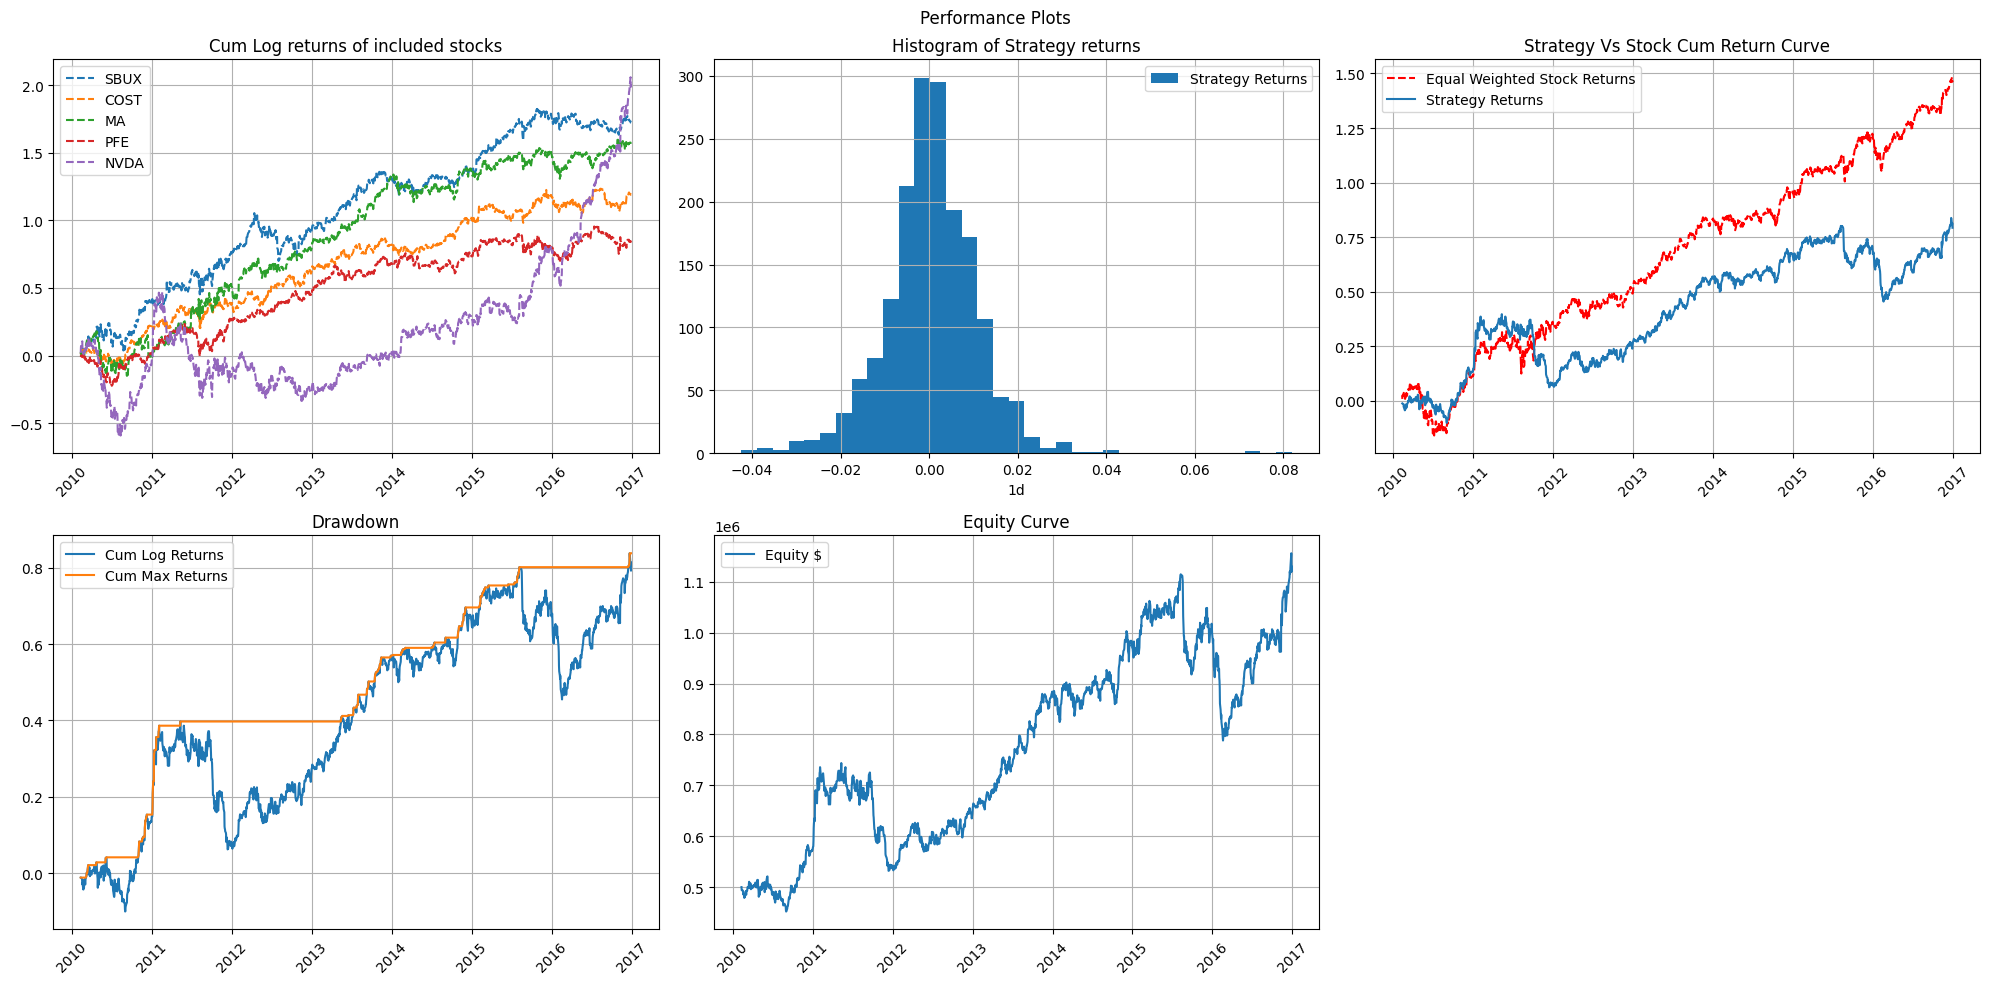

In [15]:
# Return driven results
print("Return driven results")
# Unpack the optimal parameters for the return-driven strategy
_, params, tickers = optimal_return
window1, window2, window3, vix_threshold = params  # Assign parameter values from the optimal set
coppock_params = (window1, window2, window3)  # Store the Coppock curve window parameters

# Initialize the CoppockVIX_Strategy with the selected tickers and parameters
return_driven = CoppockVIX_Strategy(
    symbol=tickers,  # List of tickers for the strategy
    benchmark=benchmark,  # Benchmark for comparison
    start=start,  # Start date of the backtest
    end=end,  # End date of the backtest
    interval=interval,  # Data interval for the backtest
    capital=capital,  # Initial capital for the strategy
    transaction_cost=transaction_cost,  # Transaction cost per trade
    verbose=verbose,  # Verbosity level for output
)

# Run the strategy with the selected Coppock curve parameters and VIX threshold
return_driven.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)
# Display the performance metrics of the strategy
return_driven.performance()
# Plot the performance charts
return_driven.performance_plots()
print("=" * 50)  # Divider between results

#### Risk Driven Approach

Risk driven results
Performance Metrics
The total capital at end of strategy: 576833.7
The annual regular returns: 2.10 %
The annual regular std deviation: 11.76 %
The annual Sharpe Ratio: 0.18
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 15.4 %
The maximum drawdown: 34.47 %
The maximum drawdown period: 837.00 days
The annual Sortino Ratio: 0.24
The annual Calmar Ratio: 0.06
Information Ratio is: -0.5578602826679906
Tracking Error is: 0.012112773479055743
Treynor Ratio is: 1.5583953543018514
Portfolio Beta is: 0.013462050557677591
Portfolio Alpha with Log Returns is: 0.019038618269492682
The total trades taken by the strategy: 17767


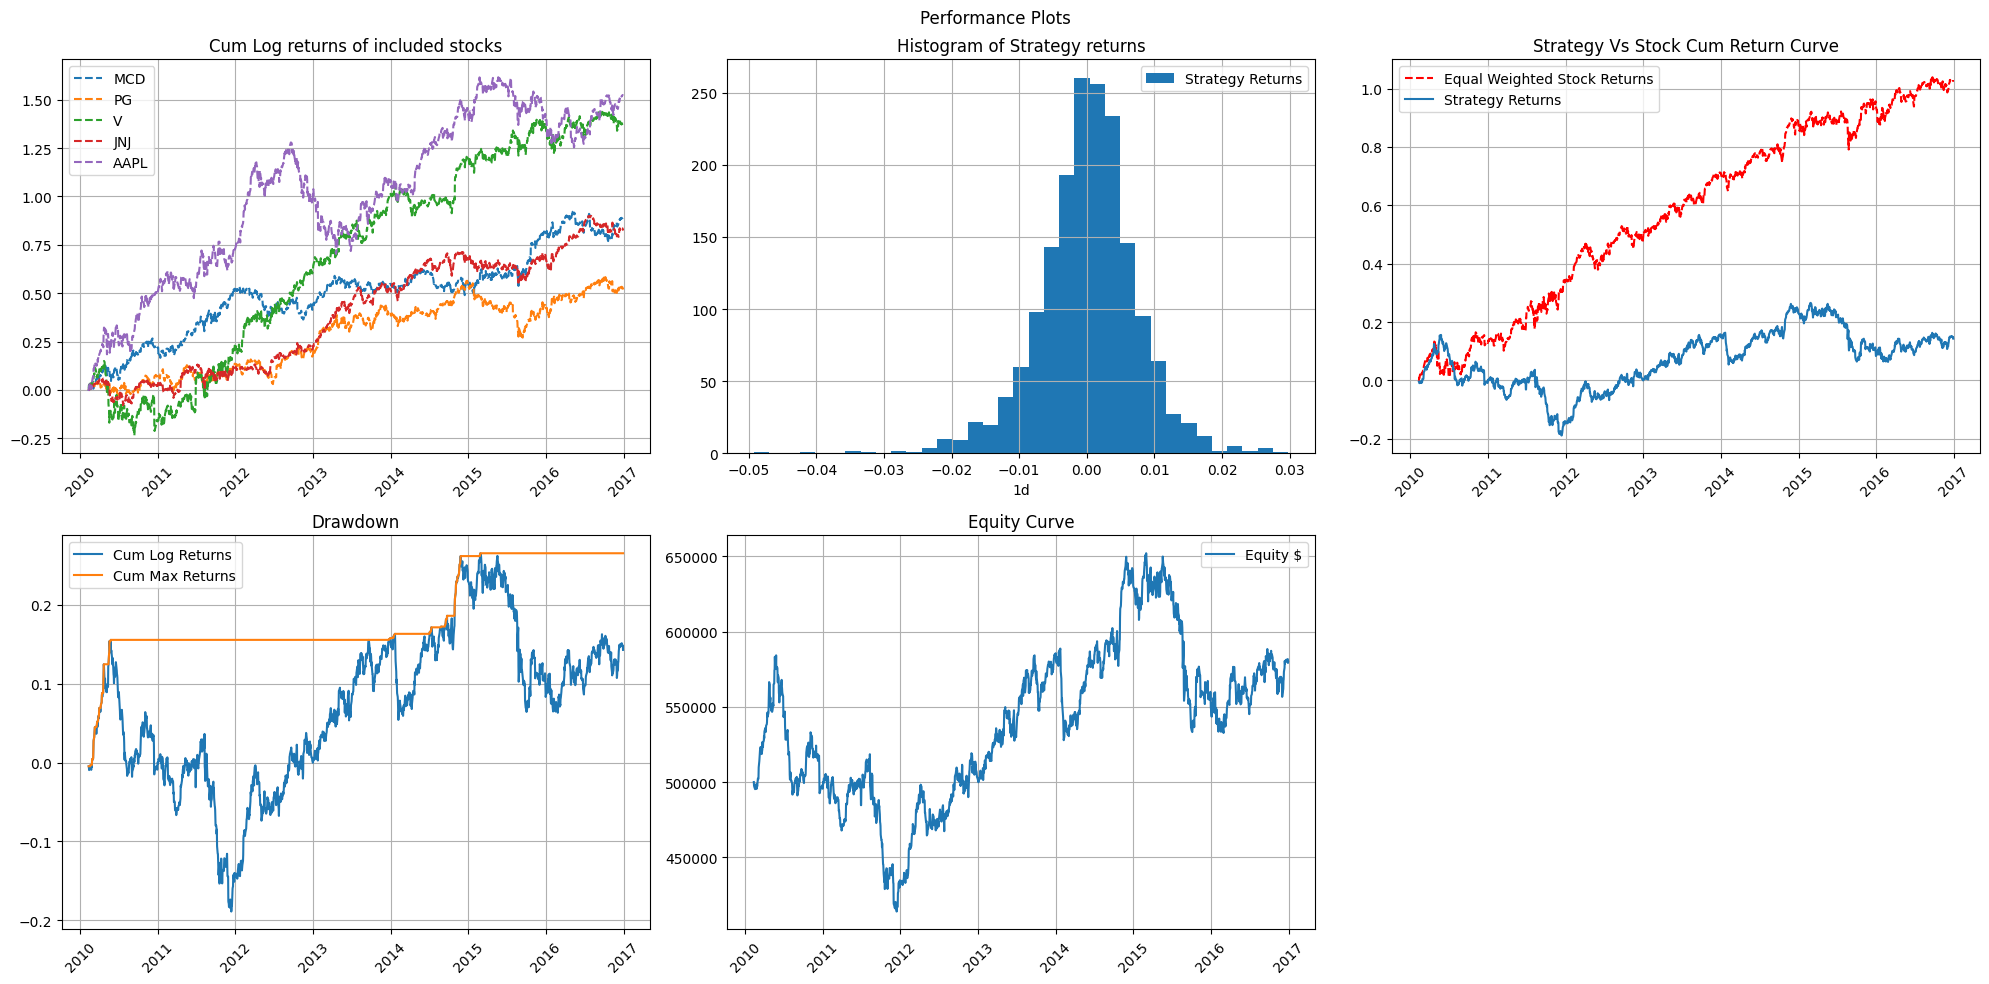

In [16]:
# Risk driven results
print("Risk driven results")
# Unpack the optimal parameters for the risk-driven strategy
_, params, tickers = optimal_risk
window1, window2, window3, vix_threshold = params  # Assign parameter values from the optimal set
coppock_params = (window1, window2, window3)  # Store the Coppock curve window parameters

# Initialize the CoppockVIX_Strategy with the selected tickers and parameters
risk_driven = CoppockVIX_Strategy(
    symbol=tickers,  # List of tickers for the strategy
    benchmark=benchmark,  # Benchmark for comparison
    start=start,  # Start date of the backtest
    end=end,  # End date of the backtest
    interval=interval,  # Data interval for the backtest
    capital=capital,  # Initial capital for the strategy
    transaction_cost=transaction_cost,  # Transaction cost per trade
    verbose=verbose,  # Verbosity level for output
)

# Run the strategy with the selected Coppock curve parameters and VIX threshold
risk_driven.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)
# Display the performance metrics of the strategy
risk_driven.performance()
# Plot the performance charts
risk_driven.performance_plots()
print("=" * 50)  # Divider between results

#### Sharpe Driven Approach

Sharpe driven results
Performance Metrics
The total capital at end of strategy: 821322.0
The annual regular returns: 7.47 %
The annual regular std deviation: 15.19 %
The annual Sharpe Ratio: 0.49
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 64.3 %
The maximum drawdown: 46.11 %
The maximum drawdown period: 1354.00 days
The annual Sortino Ratio: 0.74
The annual Calmar Ratio: 0.16
Information Ratio is: -0.2651397764122391
Tracking Error is: 0.013456788269799673
Treynor Ratio is: 3.699759779463192
Portfolio Beta is: 0.02017933039837822
Portfolio Alpha with Log Returns is: 0.06940718546299268
The total trades taken by the strategy: 17722


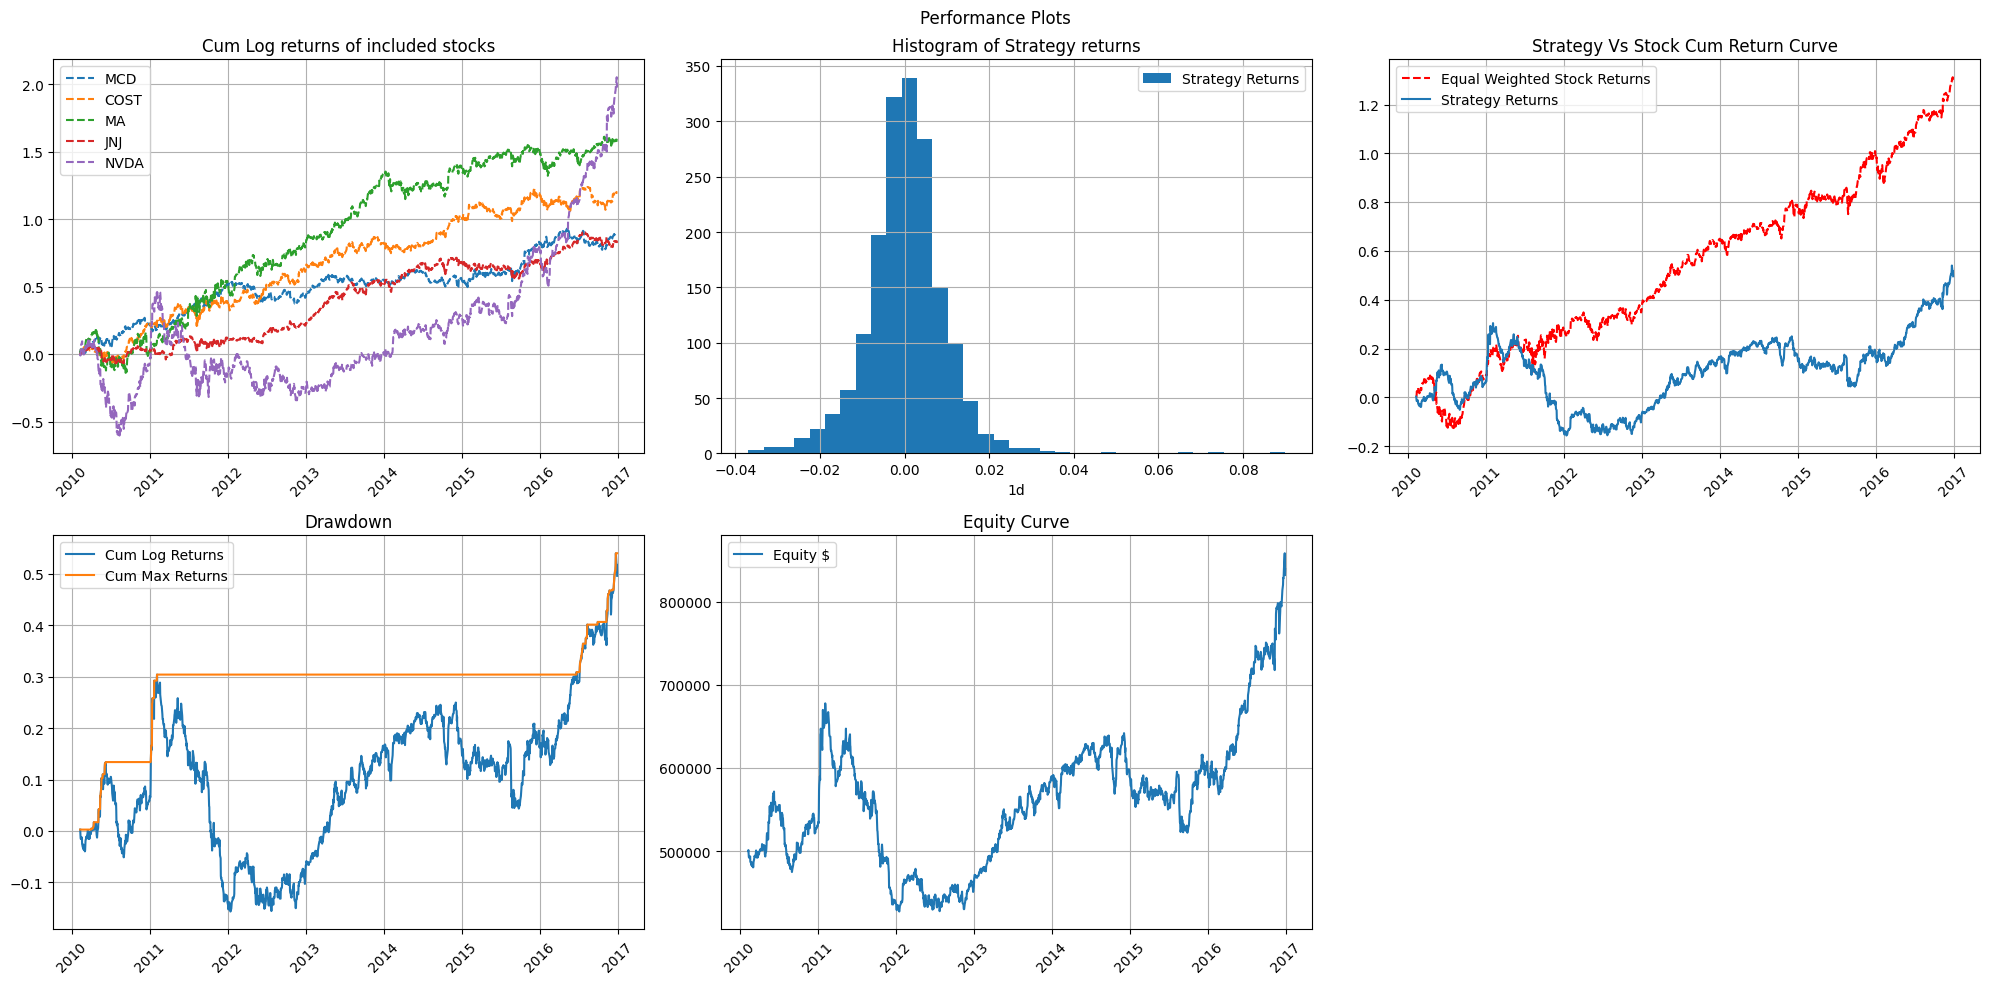

In [17]:
# Sharpe driven results
print("Sharpe driven results")
# Unpack the optimal parameters for the Sharpe ratio-driven strategy
_, params, tickers = optimal_sharpe
window1, window2, window3, vix_threshold = params  # Assign parameter values from the optimal set
coppock_params = (window1, window2, window3)  # Store the Coppock curve window parameters

# Initialize the CoppockVIX_Strategy with the selected tickers and parameters
sharpe_driven = CoppockVIX_Strategy(
    symbol=tickers,  # List of tickers for the strategy
    benchmark=benchmark,  # Benchmark for comparison
    start=start,  # Start date of the backtest
    end=end,  # End date of the backtest
    interval=interval,  # Data interval for the backtest
    capital=capital,  # Initial capital for the strategy
    transaction_cost=transaction_cost,  # Transaction cost per trade
    verbose=verbose,  # Verbosity level for output
)

# Run the strategy with the selected Coppock curve parameters and VIX threshold
sharpe_driven.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)
# Display the performance metrics of the strategy
sharpe_driven.performance()
# Plot the performance charts
sharpe_driven.performance_plots()

#### Drawdown Analysis

In summary, while all three strategies experienced notable drawdowns, they differed considerably in their recovery profiles. The return-driven approach demonstrated the quickest recovery from drawdowns, aligning with its focus on growth and resilience. The risk-driven approach had a similarly sized drawdown but took longer to recover, reflecting a conservative approach that prioritises stability over rapid recovery. The Sharpe-driven approach, with the deepest drawdown and slowest recovery, struggled the most in drawdown management, revealing areas for potential enhancement in risk control to better navigate prolonged downturns. These differences underscore each approach’s unique approach to handling losses, with varying degrees of resilience and recovery speed that cater to different investor risk tolerances.

### Helper Functions

We will define 3 helper functions. 1 to compute metrics over the entire time period, 1 to compute metrics per year and 1 function to plot the metrics.

In [18]:
# Helper function to calculate metrics over the entire time period
def calc_metrics(df, col):
    """
    Computes annual returns, annual risk and sharpe ratio over the entire period

    Parameters:
    -----------
    df  -- DataFrame containing the raw returns data
    col -- Column name to compute the metrics on

    Returns:
    --------
    DataFrame -- DataFrame containing Expected Annual Returns, Annual Risk and
    Annual Sharpe Ratio
    """

    # Calculate annual expected returns based on mean of the daily returns
    daily_ret = df[[col]].mean()  # Daily mean returns
    annual_ret = daily_ret * 252  # Multiply by 252 trading days for annual returns

    # Convert log returns back to regular returns
    annual_regular_ret = np.exp(annual_ret) - 1  # Exponentiate log returns and subtract 1

    # Calculate annual risk (standard deviation)
    daily_regular_std = (np.exp(df[[col]]) - 1).std()  # Standard deviation of daily regular returns
    annual_regular_std = daily_regular_std * (252 ** 0.5)  # Annualize the standard deviation

    # Compute Sharpe Ratio: ratio of expected returns to risk (standard deviation)
    sr = annual_regular_ret / annual_regular_std

    # Return the calculated metrics in a DataFrame for easy display and further analysis
    return pd.DataFrame({
        'Expected Annual Returns': annual_regular_ret,  # Expected returns (annualized)
        'Annual Risk': annual_regular_std,  # Risk (annualized standard deviation)
        'Annual Sharpe Ratio': sr  # Sharpe ratio
    })

# Helper function to calculate metrics by year
def calc_yearly_metrics(df, col):
    """
    Computes annual returns, annual risk and sharpe ratio by year

    Parameters:
    -----------
    df  -- DataFrame containing the raw returns data
    col -- Column name to compute the metrics on

    Returns:
    --------
    Tuple -- Tuple containing DataFrame containing Expected Annual Returns,
    Annual Risk and Annual Sharpe Ratio by year, Series containing cumulative returns
    """

    # Initialize an empty DataFrame to store yearly metrics
    yearly_metrics = pd.DataFrame()
    yearly_metrics = pd.DataFrame(columns=['Year', 'Annual Returns', 'Annual Risk', 'Sharpe Ratio'])

    # Calculate cumulative sum of log returns
    cumsum = df[col].cumsum()

    # Get the starting and ending years from the data index
    start_year = df.index.year.min()
    end_year = df.index.year.max()

    # Loop over each year in the range
    for year in range(start_year, end_year + 1):
        # Filter data for the specific year
        year_data = df[df.index.year == year][col]
        year_data = year_data.dropna()  # Remove NaN values

        # Calculate daily returns and annualize them
        daily_ret = year_data.mean()
        annual_ret = daily_ret * 252  # Annualize the returns (assuming 252 trading days in a year)
        annual_regular_ret = np.exp(annual_ret) - 1  # Convert log returns to regular returns

        # Calculate annualized risk (standard deviation)
        daily_regular_std = (np.exp(year_data) - 1).std()  # Calculate standard deviation of daily returns
        annual_regular_std = daily_regular_std * (252 ** 0.5)  # Annualize the risk

        # Calculate Sharpe Ratio
        sharpe_ratio = annual_regular_ret / annual_regular_std  # Sharpe ratio = return/risk

        # Append the results for the year to the yearly_metrics DataFrame
        yearly_metrics = pd.concat([yearly_metrics, pd.DataFrame({
            'Year': [year],
            'Annual Returns': [annual_regular_ret],
            'Annual Risk': [annual_regular_std],
            'Sharpe Ratio': [sharpe_ratio]
        })], ignore_index=True)

    # Set the index of the yearly metrics DataFrame to the column name (for better readability)
    yearly_metrics.index = [col] * (end_year + 1 - start_year)

    # Return the final DataFrame with yearly metrics
    return (yearly_metrics, cumsum)

# Function to visualize portfolio metrics (Annual Returns, Risk, and Sharpe Ratio) by year
def viz_metrics_by_year(results, cumsums):
    """
    Visualises annual returns, annual risk and sharpe ratio by year for all
    unique portfolios in the `results` DataFrame.

    Parameters:
    -----------
    results -- DataFrame containing Expected Annual Returns, Annual Risk
    and Annual Sharpe Ratio by year for unique portfolios
    cumsums -- Cumulative returns for each unique portfolio

    Returns:
    --------
    Figure -- Figure object storing all the plots generated.
    """

    # Create a new figure with a specific size for the plots
    fig = plt.figure(figsize=(15, 20))
    portfolios = results.index.unique()

    # First subplot: Plot Expected Annual Returns over the years
    plt.subplot(4, 1, 1)  # Divide the plot into 3 rows and 1 column, this is the first plot
    for portfolio in portfolios:  # Loop through the list of portfolios
        # Extract the Annual Returns and Year columns for the specific portfolio
        ret = results.loc[portfolio][["Annual Returns", "Year"]]

        # Plot the Annual Returns against the Year, with markers for each data point
        plt.plot(
            ret["Year"], ret["Annual Returns"], marker="o", label=portfolio  # Use 'o' as markers
        )

    # Add a title and labels for the first plot
    plt.title("Expected Annual Returns Over the Years")
    plt.xlabel("Year")  # Label for the x-axis
    plt.ylabel("Returns")  # Label for the y-axis
    plt.legend()  # Show a legend to label the portfolios
    plt.grid()  # Display grid lines on the plot

    # Second subplot: Plot Annual Risk over the years
    plt.subplot(4, 1, 2)  # Second plot in the same figure
    for portfolio in portfolios:  # Loop through each portfolio again
        # Extract the Annual Risk and Year columns for the specific portfolio
        risk = results.loc[portfolio][["Annual Risk", "Year"]]

        # Plot the Annual Risk against the Year
        plt.plot(risk["Year"], risk["Annual Risk"], marker="o", label=portfolio)

    # Add a title and labels for the second plot
    plt.title("Risk Over the Years")
    plt.xlabel("Year")  # Label for the x-axis
    plt.ylabel("Risk")  # Label for the y-axis
    plt.legend()  # Show a legend to label the portfolios
    plt.grid()  # Display grid lines

    # Third subplot: Plot Sharpe Ratio over the years
    plt.subplot(4, 1, 3)  # Third in the same figure
    for portfolio in portfolios:  # Loop through the portfolios again
        # Extract the Sharpe Ratio and Year columns for the specific portfolio
        sr = results.loc[portfolio][["Sharpe Ratio", "Year"]]

        # Plot the Sharpe Ratio against the Year
        plt.plot(sr["Year"], sr["Sharpe Ratio"], marker="o", label=portfolio)

    # Add a title and labels for the third plot
    plt.title("Sharpe Ratios Over the Years")
    plt.xlabel("Year")  # Label for the x-axis
    plt.ylabel("Sharpe Ratio")  # Label for the y-axis
    plt.legend()  # Show a legend to label the portfolios
    plt.grid()  # Display grid lines

    # Fourth subplot: Plot Cumulative Returns over the years
    plt.subplot(4, 1, 4)  # Fourth and last plot in the figure
    portfolios = cumsums.columns
    plt.plot(cumsums, label=portfolios, linestyle='dashed')

    # Add a title and labels for the fourth plot
    plt.title("Strategy Variations Vs Benchmark Cum Return Curve")
    plt.xlabel("Year")  # Label for the x-axis
    plt.ylabel("Cumulative Returns")  # Label for the y-axis
    plt.legend()  # Show a legend to label the portfolios
    plt.grid()  # Display grid lines

    # Adjust the layout so the plots don't overlap
    plt.tight_layout()
    plt.show()  # Display the plots

    return fig  # Return the figure object for further use (if needed)

### Comparison of 3 variations during Training Period

In [19]:
# We start by fetching and processing our second benchmark data (^DJI)
start = "2010-01-01"
end = "2019-12-31"
interval = return_driven.interval
ticker = "DIA"

hist_stock = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
dji_returns = pd.DataFrame()
dji_returns["Close_Price"] =  hist_stock["Close"]

# Calculate log returns for DJIA
dji_returns["Return_DIA"] = np.log(dji_returns["Close_Price"] / dji_returns["Close_Price"].shift(1))
dji_returns = dji_returns.dropna()
dji_returns.index = pd.to_datetime(dji_returns.index.strftime("%Y-%m-%d"))

RETROSPECTIVE ANALYSIS OF METRICS GENERATED ON TRAINING DATA


Expected Annual Returns  Annual Risk  \
Portfolio Strategy (Return Driven)                     0.12         0.17   
Portfolio Strategy (Risk Driven)                       0.02         0.12   
Portfolio Strategy (Sharpe Driven)                     0.07         0.15   

                                    Annual Sharpe Ratio  
Portfolio Strategy (Return Driven)                 0.72  
Portfolio Strategy (Risk Driven)                   0.18  
Portfolio Strategy (Sharpe Driven)                 0.49

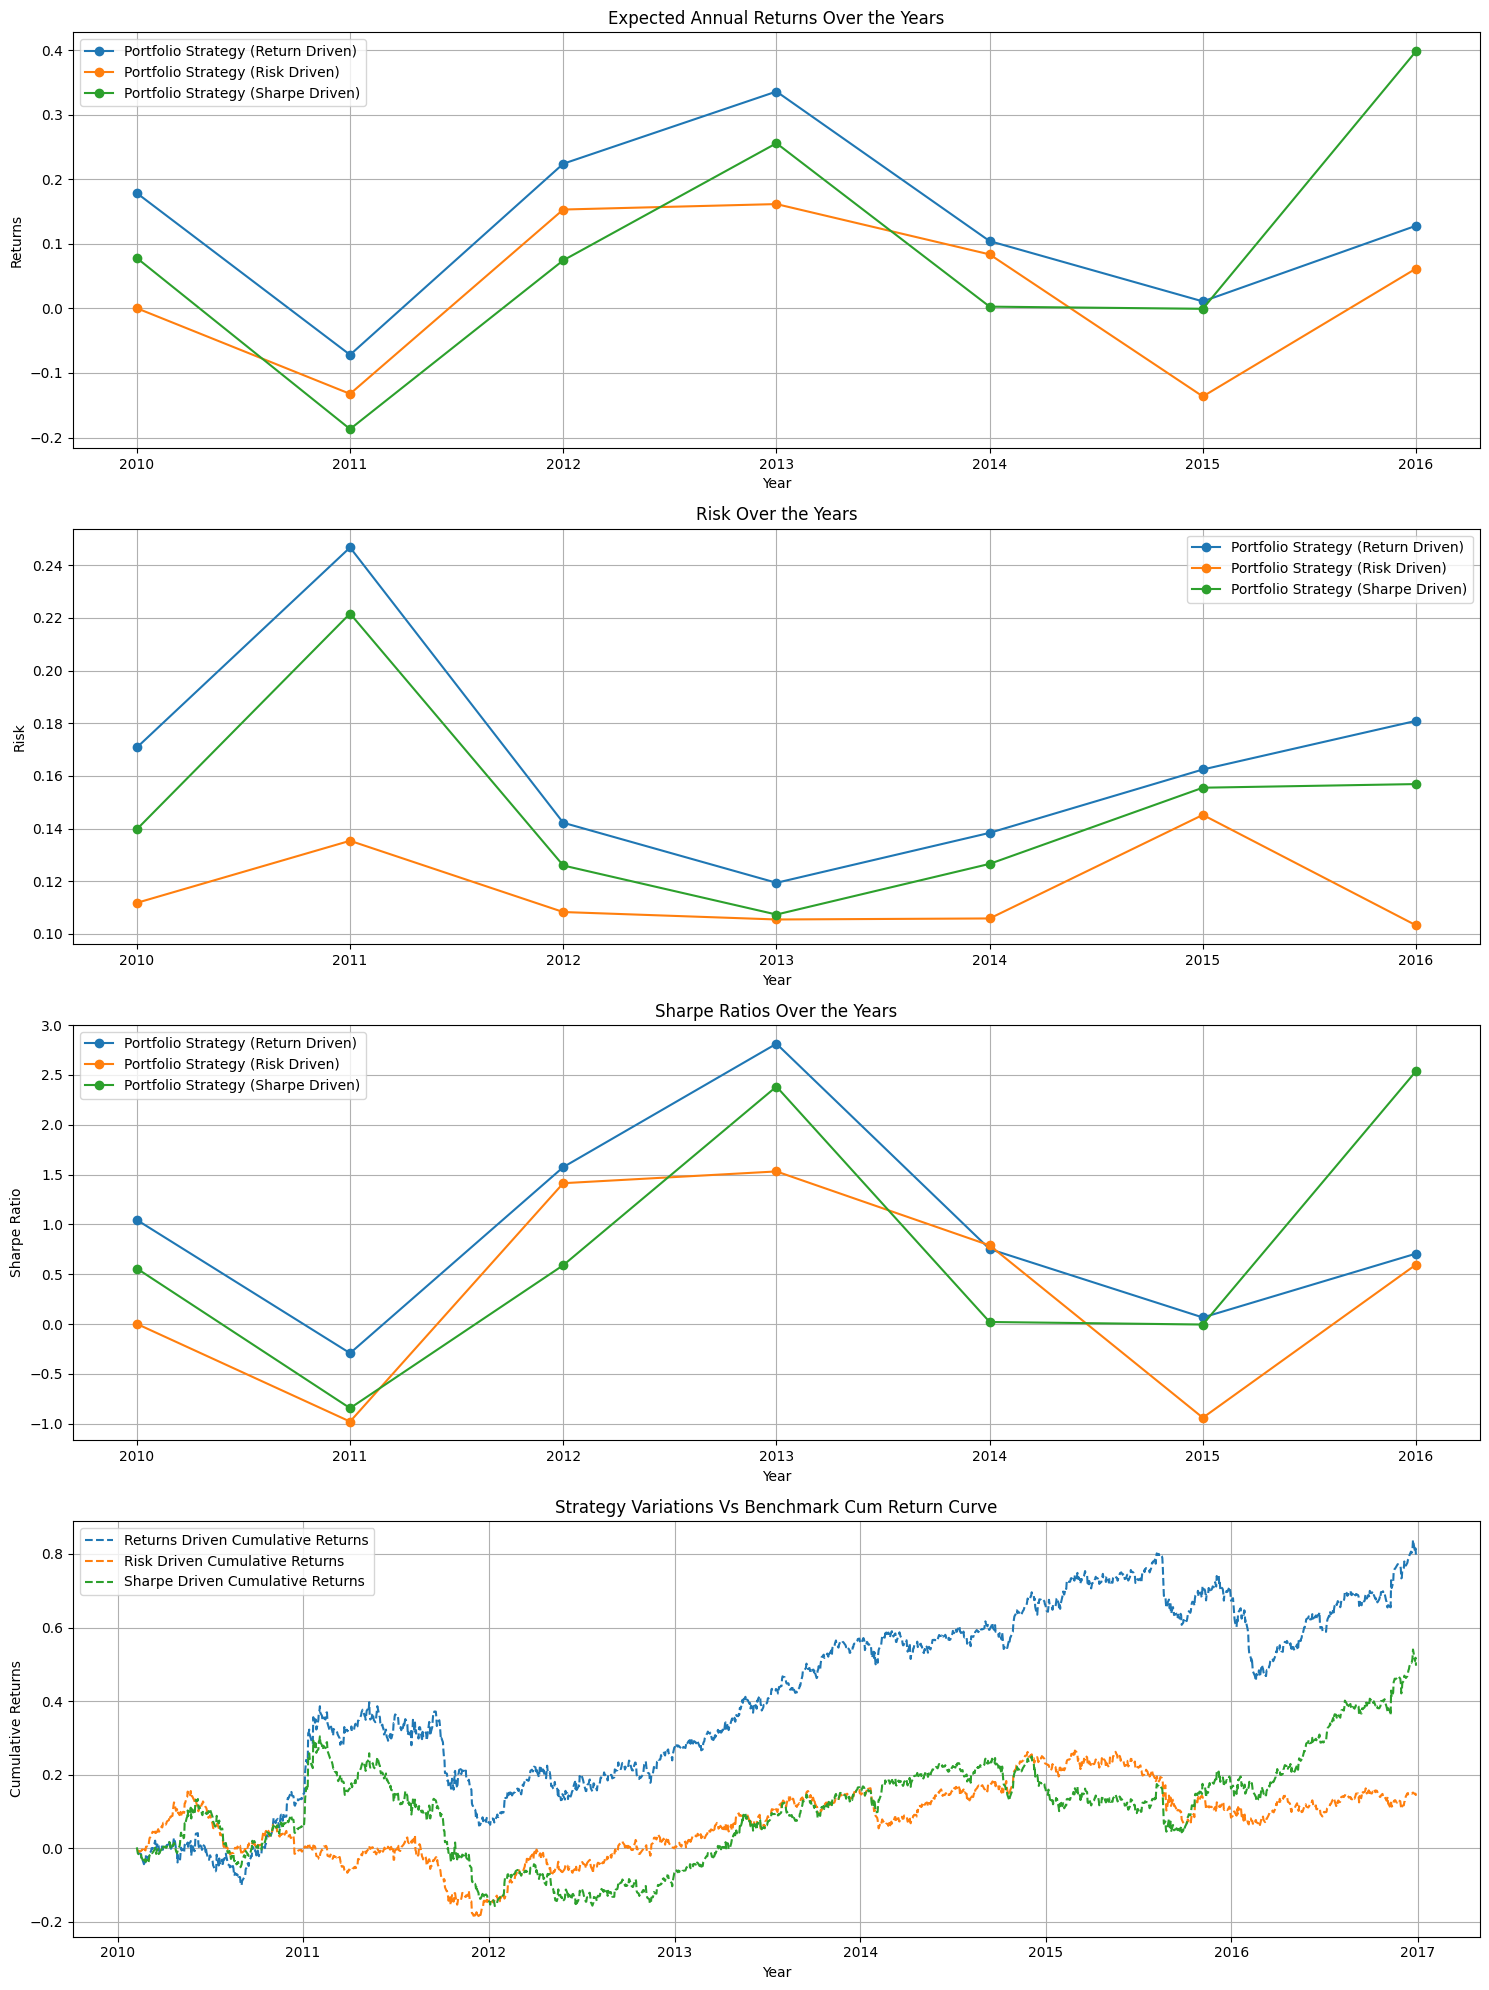

In [20]:
# Retrospective analysis
# Compute benchmark statistics (S&P500)
print("=" * 50)
print("RETROSPECTIVE ANALYSIS OF METRICS GENERATED ON TRAINING DATA")
train_results_data = return_driven.Final_result_data.copy()  # Get the return drive results data from the strategy
train_results_data = train_results_data.merge(dji_returns, left_index=True, right_index=True)  # Add in the DJIA data

# Compute metrics
train_ret_strategy_metrics = calc_metrics(train_results_data, "capital_log_returns")  # Calculate metrics for the strategy on return-driven parameters
train_risk_strategy_metrics = calc_metrics(risk_driven.Final_result_data.copy(), "capital_log_returns")  # Calculate metrics for the strategy on risk-driven parameters
train_sharpe_strategy_metrics = calc_metrics(sharpe_driven.Final_result_data.copy(), "capital_log_returns")  # Calculate metrics for the strategy on sharpe-driven parameters

# Combine the metrics for the strategy variations, stock portfolio, and benchmark
train_comparison_df = pd.concat(
    [
        train_ret_strategy_metrics,
        train_risk_strategy_metrics,
        train_sharpe_strategy_metrics,
    ], ignore_index=True)

train_comparison_df.index = [
    "Portfolio Strategy (Return Driven)",
    "Portfolio Strategy (Risk Driven)",
    "Portfolio Strategy (Sharpe Driven)",
] # Assign meaningful labels to the index

# Display the comparison of portfolio metrics (returns, risk, Sharpe ratio)
display(train_comparison_df)

# Compute yearly statistics (for each year in the dataset)
yearly_train_ret_strategy_metrics, ret_strategy_cumsum = calc_yearly_metrics(train_results_data, "capital_log_returns")  # Yearly metrics for the strategy on return-driven parameters
yearly_train_risk_strategy_metrics, risk_strategy_cumsum = calc_yearly_metrics(risk_driven.Final_result_data.copy(), "capital_log_returns")  # Yearly metrics for the strategy on risk-driven parameters
yearly_train_sharpe_strategy_metrics, sharpe_strategy_cumsum = calc_yearly_metrics(sharpe_driven.Final_result_data.copy(), "capital_log_returns")  # Yearly metrics for the strategy on sharpe-driven parameters

# Combine the yearly metrics for comparison
train_yearly_comparison_df = pd.concat(
    [
        yearly_train_ret_strategy_metrics, # Yearly metrics for the strategy on return-driven parameters
        yearly_train_risk_strategy_metrics, # Yearly metrics for the strategy on risk-driven parameters
        yearly_train_sharpe_strategy_metrics, # Yearly metrics for the strategy on sharpe-driven parameters
    ])

# Rename the index for clarity (to make it more readable)
train_yearly_comparison_df.index = ["Portfolio Strategy (Return Driven)"] * 7 + \
    ["Portfolio Strategy (Risk Driven)"] * 7 + \
    ["Portfolio Strategy (Sharpe Driven)"] * 7

train_cumsums = pd.DataFrame({
    "Returns Driven Cumulative Returns": ret_strategy_cumsum,
    "Risk Driven Cumulative Returns": risk_strategy_cumsum,
    "Sharpe Driven Cumulative Returns": sharpe_strategy_cumsum,
})

# Display the yearly comparison of portfolio metrics
fig2 = viz_metrics_by_year(train_yearly_comparison_df, train_cumsums)  # Call the visualization function to plot the metrics over time

### Training Period Summary
The Return Driven Approach emerges as the best-performing strategy overall for several reasons:
- Highest absolute returns with proportionate risk management
- Superior risk-adjusted performance across multiple metrics (Sharpe, Sortino, and Calmar Ratios)
- Very low beta (0.0468), reflecting minimal market dependence
- Highest alpha, representing strong excess return in relation to benchmark SPY ETF
- Best benchmark-relative performance (least negative Information Ratio)
- Balanced Tracking Error, suggesting adherence to the benchmark while achieving excess returns
- Strong Treynor Ratio, highlighting efficient use of systematic risk



## **Testing Period**
---
In this section, the financial metrics for each individual variation during the testing period would be computed. We then compare the performance of the variations against the benchmark.

### Comparison against Benchmark
We will now compare our results against the S&P500 Index ETF, SPY, as a benchmark, along with the Dow Jones Industrial Average Index ETF, DIA. We will first look at the drawdown, followed by the overall annual expected returns, annual risk and annual sharpe ratio, then zoom in to observe how these metrics change over time.

### Individual Analysis on the 3 Portfolio Variations during Testing Period

With our strategy tuned and our portfolio of 5 stocks shortlisted, we will now analyse its performance in the testing phase.

In [21]:
# Fixed parameters specified by project guidelines
benchmark = "SPY"  # Benchmark for comparison
start = "2017-01-01"  # Start date for the backtest
end = "2019-12-31"  # End date for the backtest
interval = "1d"  # Interval for stock price data
capital = 500000  # Initial capital for the strategy
transaction_cost = 0.00  # Transaction cost per trade
verbose = 1  # Verbosity level (1 for some output)

#### Return Driven Approach

Return driven results
Performance Metrics
The total capital at end of strategy: 856728.5
The annual regular returns: 20.55 %
The annual regular std deviation: 17.06 %
The annual Sharpe Ratio: 1.20
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 71.3 %
The maximum drawdown: 19.04 %
The maximum drawdown period: 151.00 days
The annual Sortino Ratio: 1.68
The annual Calmar Ratio: 1.08
Information Ratio is: 0.2234162909576075
Tracking Error is: 0.013626774597893925
Treynor Ratio is: -13.648251087450095
Portfolio Beta is: -0.015059299500524665
Portfolio Alpha with Log Returns is: 0.1890089874114357
The total trades taken by the strategy: 7350


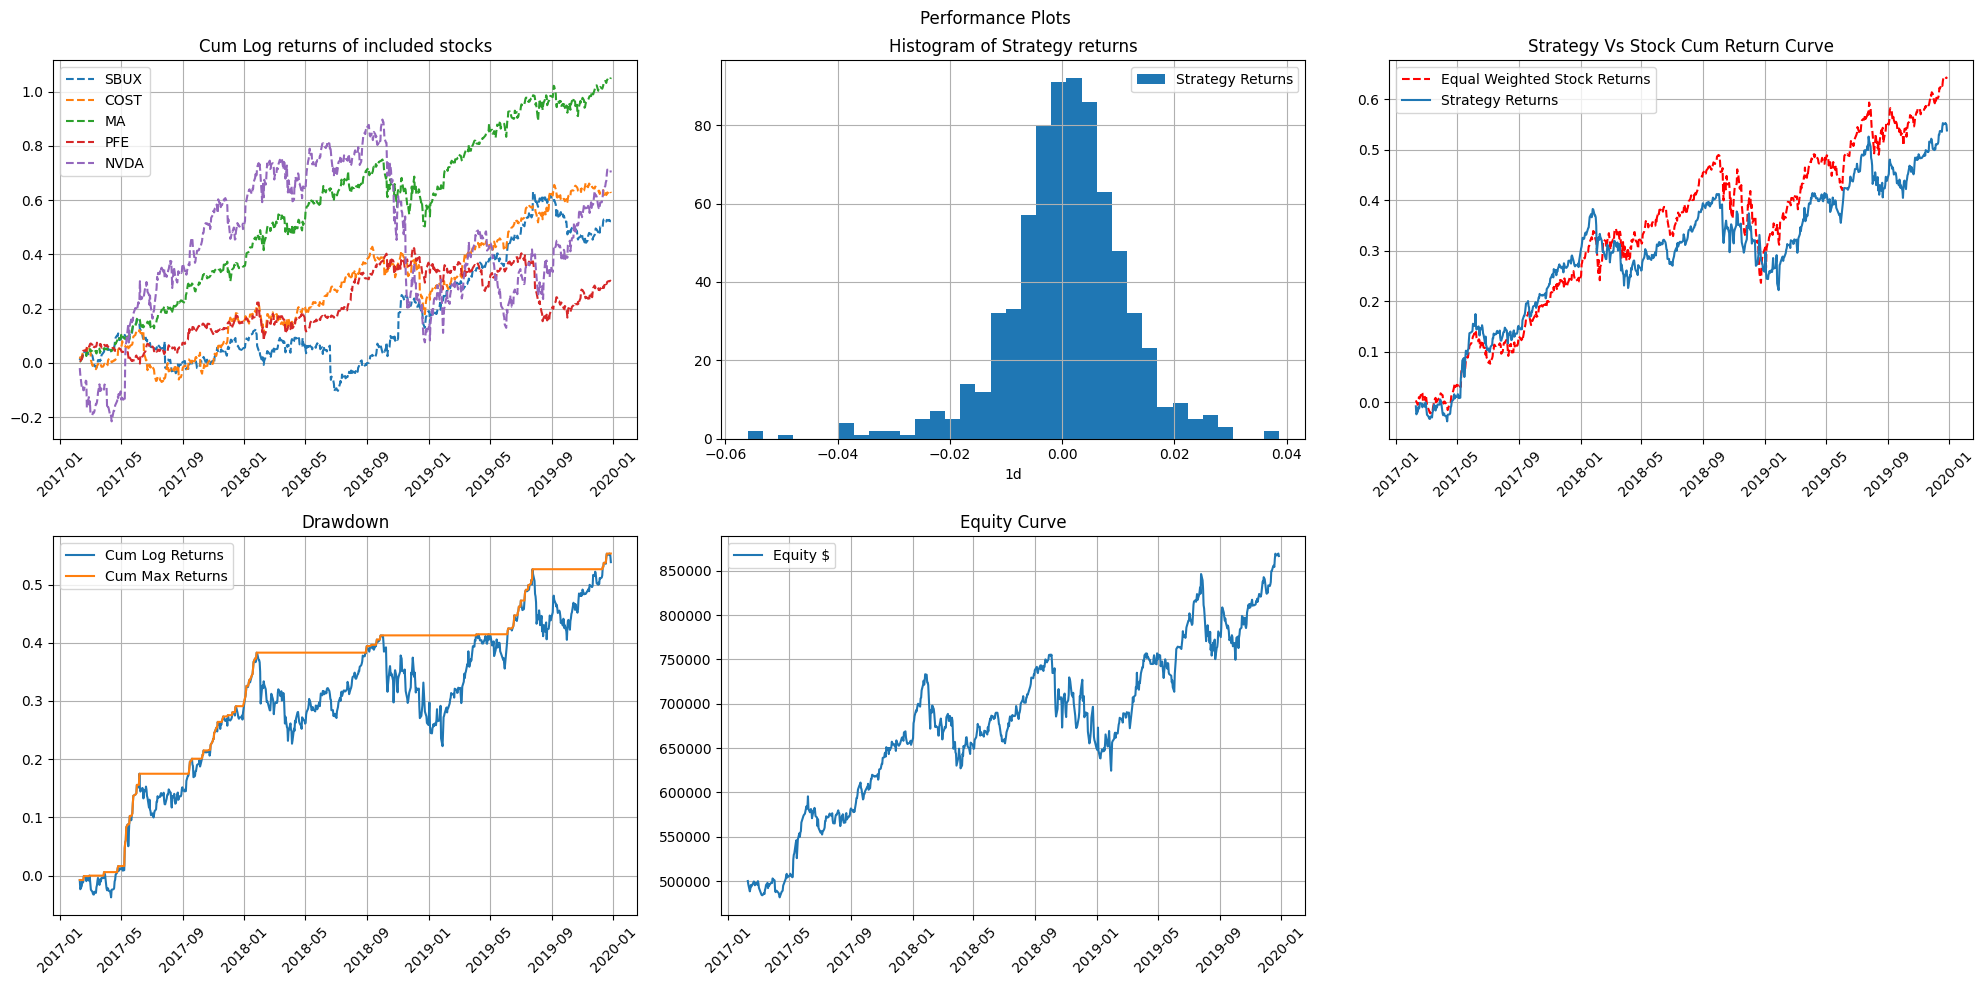

In [22]:
# Return driven results
print("Return driven results")
# Unpack the optimal parameters for the return-driven strategy
_, params, tickers = optimal_return
window1, window2, window3, vix_threshold = params  # Assign parameter values from the optimal set
coppock_params = (window1, window2, window3)  # Store the Coppock curve window parameters

# Initialize the CoppockVIX_Strategy with the selected tickers and parameters
test_return_driven = CoppockVIX_Strategy(
    symbol=tickers,  # List of tickers for the strategy
    benchmark=benchmark,  # Benchmark for comparison
    start=start,  # Start date of the backtest
    end=end,  # End date of the backtest
    interval=interval,  # Data interval for the backtest
    capital=capital,  # Initial capital for the strategy
    transaction_cost=transaction_cost,  # Transaction cost per trade
    verbose=verbose,  # Verbosity level for output
)

# Run the strategy with the selected Coppock curve parameters and VIX threshold
test_return_driven.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)
# Display the performance metrics of the strategy
test_return_driven.performance()
# Plot the performance charts
test_return_driven.performance_plots()
print("=" * 50)  # Divider between results

#### Risk Driven Approach

Risk driven results
Performance Metrics
The total capital at end of strategy: 725942.0
The annual regular returns: 13.82 %
The annual regular std deviation: 12.02 %
The annual Sharpe Ratio: 1.15
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 45.2 %
The maximum drawdown: 21.71 %
The maximum drawdown period: 300.00 days
The annual Sortino Ratio: 1.61
The annual Calmar Ratio: 0.64
Information Ratio is: -0.052685054576876195
Tracking Error is: 0.01096390643304382
Treynor Ratio is: 3.878045743985348
Portfolio Beta is: 0.035629201478335884
Portfolio Alpha with Log Returns is: 0.12448522742653398
The total trades taken by the strategy: 7372


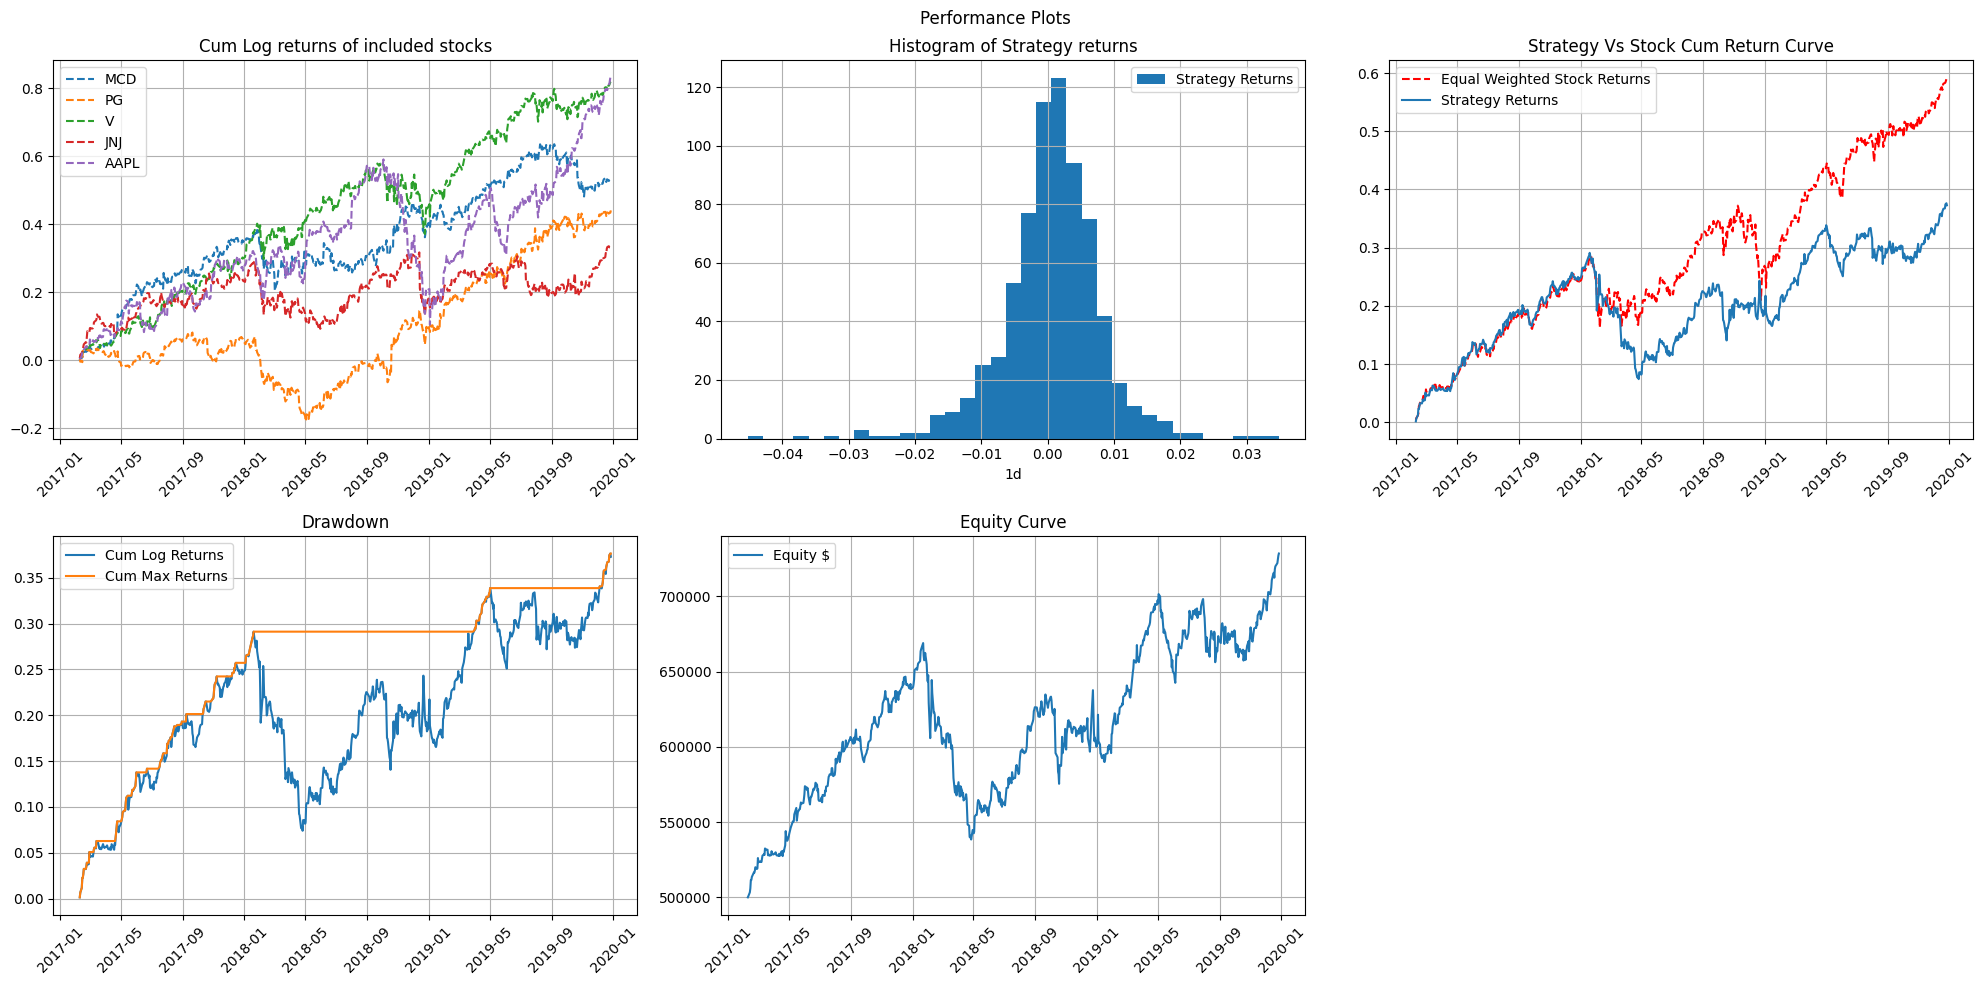

In [23]:
# Risk driven results
print("Risk driven results")
# Unpack the optimal parameters for the risk-driven strategy
_, params, tickers = optimal_risk
window1, window2, window3, vix_threshold = params  # Assign parameter values from the optimal set
coppock_params = (window1, window2, window3)  # Store the Coppock curve window parameters

# Initialize the CoppockVIX_Strategy with the selected tickers and parameters
test_risk_driven = CoppockVIX_Strategy(
    symbol=tickers,  # List of tickers for the strategy
    benchmark=benchmark,  # Benchmark for comparison
    start=start,  # Start date of the backtest
    end=end,  # End date of the backtest
    interval=interval,  # Data interval for the backtest
    capital=capital,  # Initial capital for the strategy
    transaction_cost=transaction_cost,  # Transaction cost per trade
    verbose=verbose,  # Verbosity level for output
)

# Run the strategy with the selected Coppock curve parameters and VIX threshold
test_risk_driven.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)
# Display the performance metrics of the strategy
test_risk_driven.performance()
# Plot the performance charts
test_risk_driven.performance_plots()
print("=" * 50)  # Divider between results

#### Sharpe Driven Approach

Sharpe driven results
Performance Metrics
The total capital at end of strategy: 736316.4
The annual regular returns: 14.34 %
The annual regular std deviation: 16.42 %
The annual Sharpe Ratio: 0.87
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 47.3 %
The maximum drawdown: 29.30 %
The maximum drawdown period: 170.00 days
The annual Sortino Ratio: 1.20
The annual Calmar Ratio: 0.49
Information Ratio is: -0.02256135396314673
Tracking Error is: 0.013126045407610403
Treynor Ratio is: 7.2609297947701545
Portfolio Beta is: 0.019745313527151503
Portfolio Alpha with Log Returns is: 0.13124116949567532
The total trades taken by the strategy: 7414


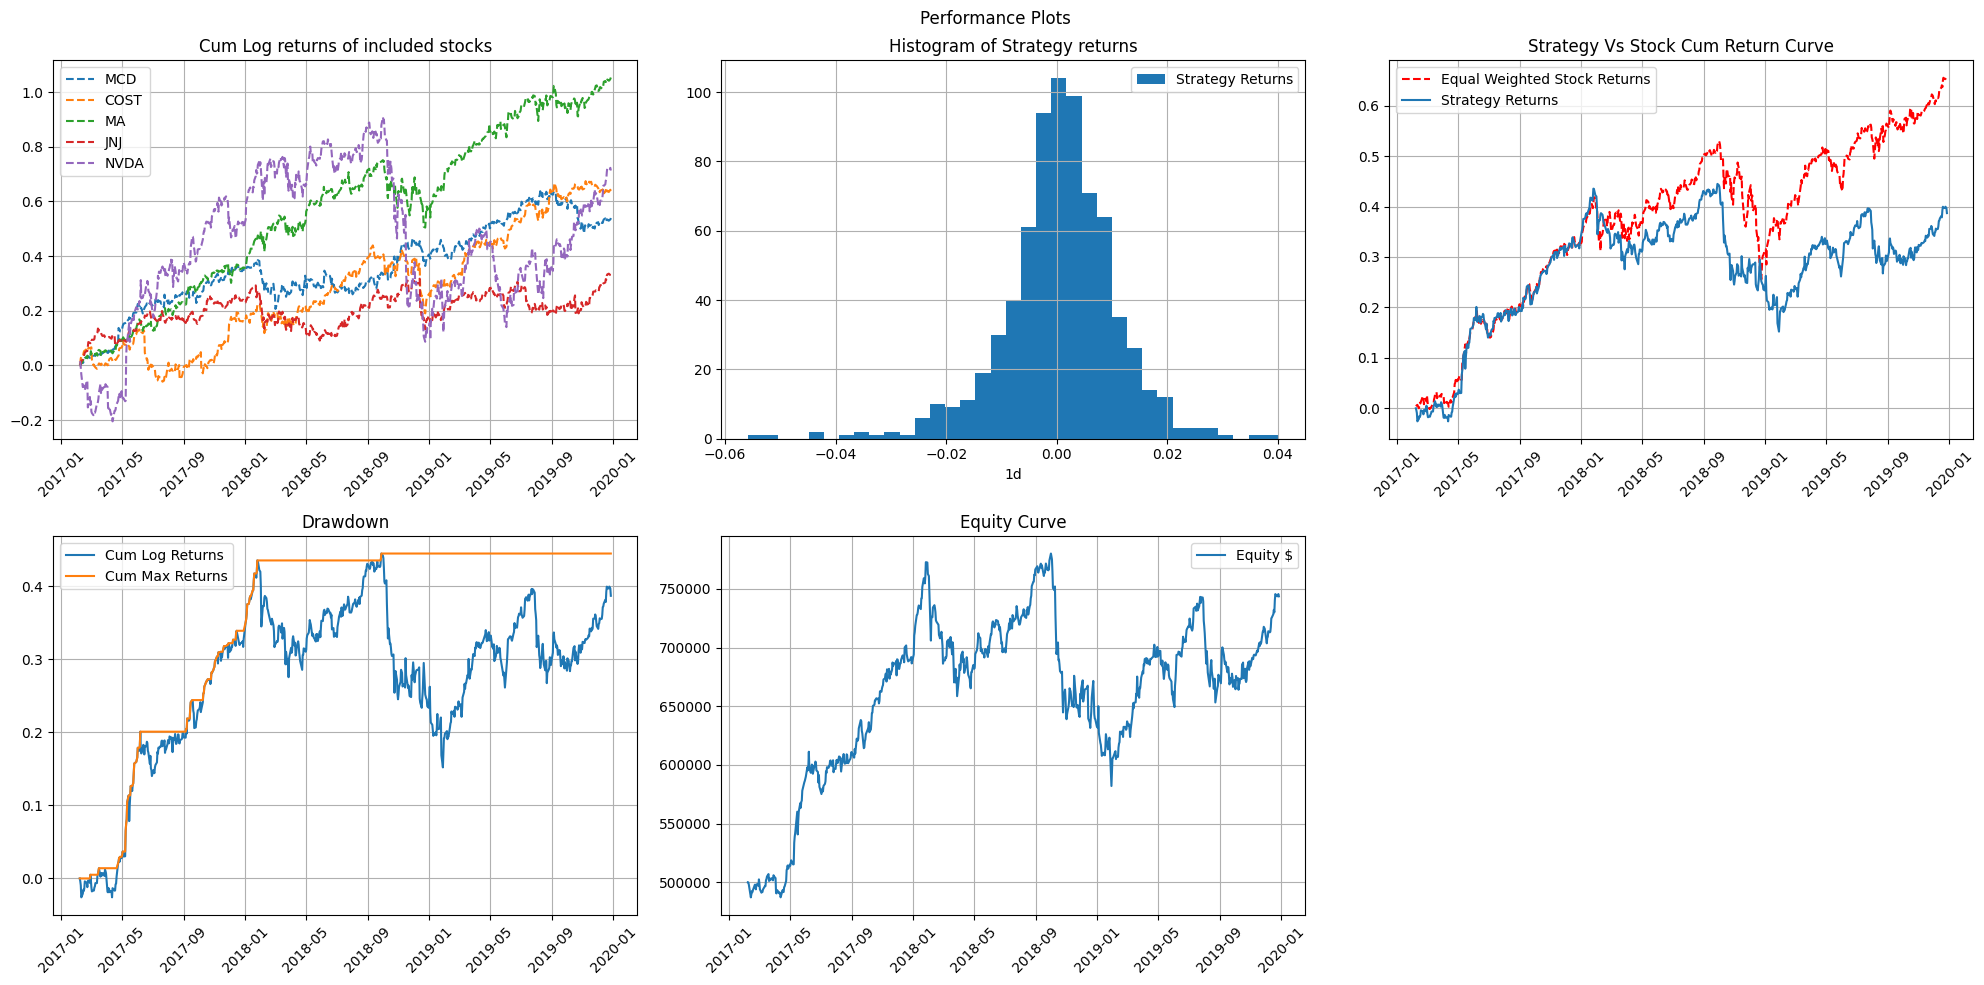

In [24]:
# Sharpe driven results
print("Sharpe driven results")
# Unpack the optimal parameters for the Sharpe ratio-driven strategy
_, params, tickers = optimal_sharpe
window1, window2, window3, vix_threshold = params  # Assign parameter values from the optimal set
coppock_params = (window1, window2, window3)  # Store the Coppock curve window parameters

# Initialize the CoppockVIX_Strategy with the selected tickers and parameters
test_sharpe_driven = CoppockVIX_Strategy(
    symbol=tickers,  # List of tickers for the strategy
    benchmark=benchmark,  # Benchmark for comparison
    start=start,  # Start date of the backtest
    end=end,  # End date of the backtest
    interval=interval,  # Data interval for the backtest
    capital=capital,  # Initial capital for the strategy
    transaction_cost=transaction_cost,  # Transaction cost per trade
    verbose=verbose,  # Verbosity level for output
)

# Run the strategy with the selected Coppock curve parameters and VIX threshold
test_sharpe_driven.run_strategy(coppock_params=coppock_params, vix_threshold=vix_threshold)
# Display the performance metrics of the strategy
test_sharpe_driven.performance()
# Plot the performance charts
test_sharpe_driven.performance_plots()

### Drawdown Comparison to Benchmarks
Below, we have calculated and plotted the drawdown for the SPY ETF as well as the DIA ETF as a benchmark for our various approaches.

[*********************100%***********************]  1 of 1 completed

The maximum drawdown: 25.93 %
The maximum drawdown period: 204 days


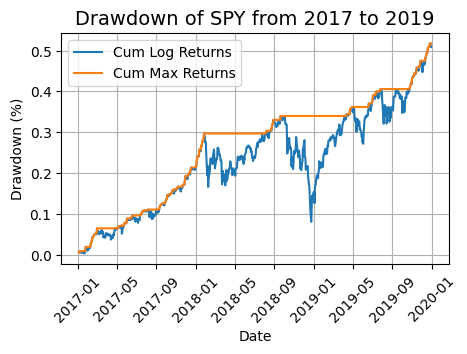

[*********************100%***********************]  1 of 1 completed

The maximum drawdown: 25.44 %
The maximum drawdown period: 235 days


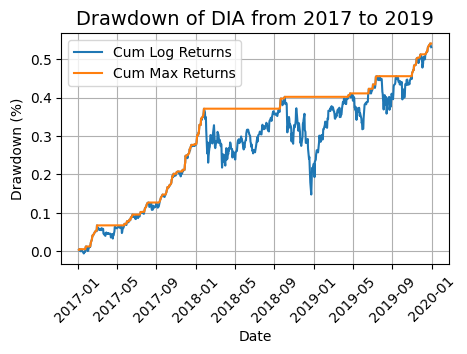

In [25]:
# Step 1: Download SPY data
ticker = 'SPY'
start='2017-01-01'
end='2019-12-31'

def benchmarkDrawdown(ticker, start, end):
  """Plot drawdown for benchmark

    Parameters:
    -----------
    tickers (list): List of stock ticker symbols
    start_date (str): Start date for analysis in 'YYYY-MM-DD' format
    end_date (str): End date for analysis in 'YYYY-MM-DD' format

  """
  data = yf.download(ticker, start, end)

  # Step 1: Calculate daily returns
  data['Daily_Return'] = data['Adj Close'].pct_change()

  # Step 2: Calculate cumulative gross returns (compounding daily returns)
  data['Gross_Cumulative_Return'] = (1 + data['Daily_Return']).cumprod() - 1

  # Step 3: Calculate the cumulative maximum price (peak value)
  data['Cumulative_Max'] = data['Gross_Cumulative_Return'].cummax()

  # Step 4: Calculate the drawdown (difference between the current value and the peak)
  data['Drawdown'] = data['Cumulative_Max'] - data['Gross_Cumulative_Return']


  print("The maximum drawdown: {:.2f} %".format(data['Drawdown'].max() * 100))
  zero_periods = data[data['Drawdown'] == 0]
  delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
  print("The maximum drawdown period: {0} days".format(delta_values.max().days))


  # Step 5: Plot the drawdown
  plt.figure(figsize=(5,3))
  plt.plot(data.index, data['Gross_Cumulative_Return'], label='Cum Log Returns')
  plt.plot(data.index, data['Cumulative_Max'], label='Cum Max Returns')
  plt.title(f"Drawdown of {ticker} from 2017 to 2019", fontsize=14)
  plt.xlabel("Date")
  plt.xticks(rotation=45)
  plt.ylabel("Drawdown (%)")
  plt.grid(True)
  plt.legend()
  plt.show()

benchmarkDrawdown('SPY', start, end)
benchmarkDrawdown('DIA', start, end)

##### Drawdown Analysis Against Benchmarks

Overall, the return-driven approach outperforms the other approaches and benchmarks by providing the lowest maximum drawdown, representing the lowest severity of downside-risk while also presenting the lowest maximum drawdown period over the testing period, which represents a stronger recovery in periods of downturn. As such, the return-driven approach presents the overall best-protection to downside risk.

### Comparison of 3 Portfolio Variations during Testing Period

#### Financial Metrics against benchmark (Testing Period)
 Next, we will be looking at the expected
 annual returns, annual risk as well as annual sharpe ratio for the various portfolios against the benchmark to compare and evaluate them.

ANALYSIS OF METRICS GENERATED ON TESTING DATA


Expected Annual Returns  Annual Risk  \
Portfolio Strategy (Return Driven)                     0.21         0.17   
Portfolio Strategy (Risk Driven)                       0.14         0.12   
Portfolio Strategy (Sharpe Driven)                     0.14         0.16   
SPY                                                    0.15         0.13   
DIA                                                    0.16         0.13   

                                    Annual Sharpe Ratio  
Portfolio Strategy (Return Driven)                 1.20  
Portfolio Strategy (Risk Driven)                   1.15  
Portfolio Strategy (Sharpe Driven)                 0.87  
SPY                                                1.14  
DIA                                                1.18

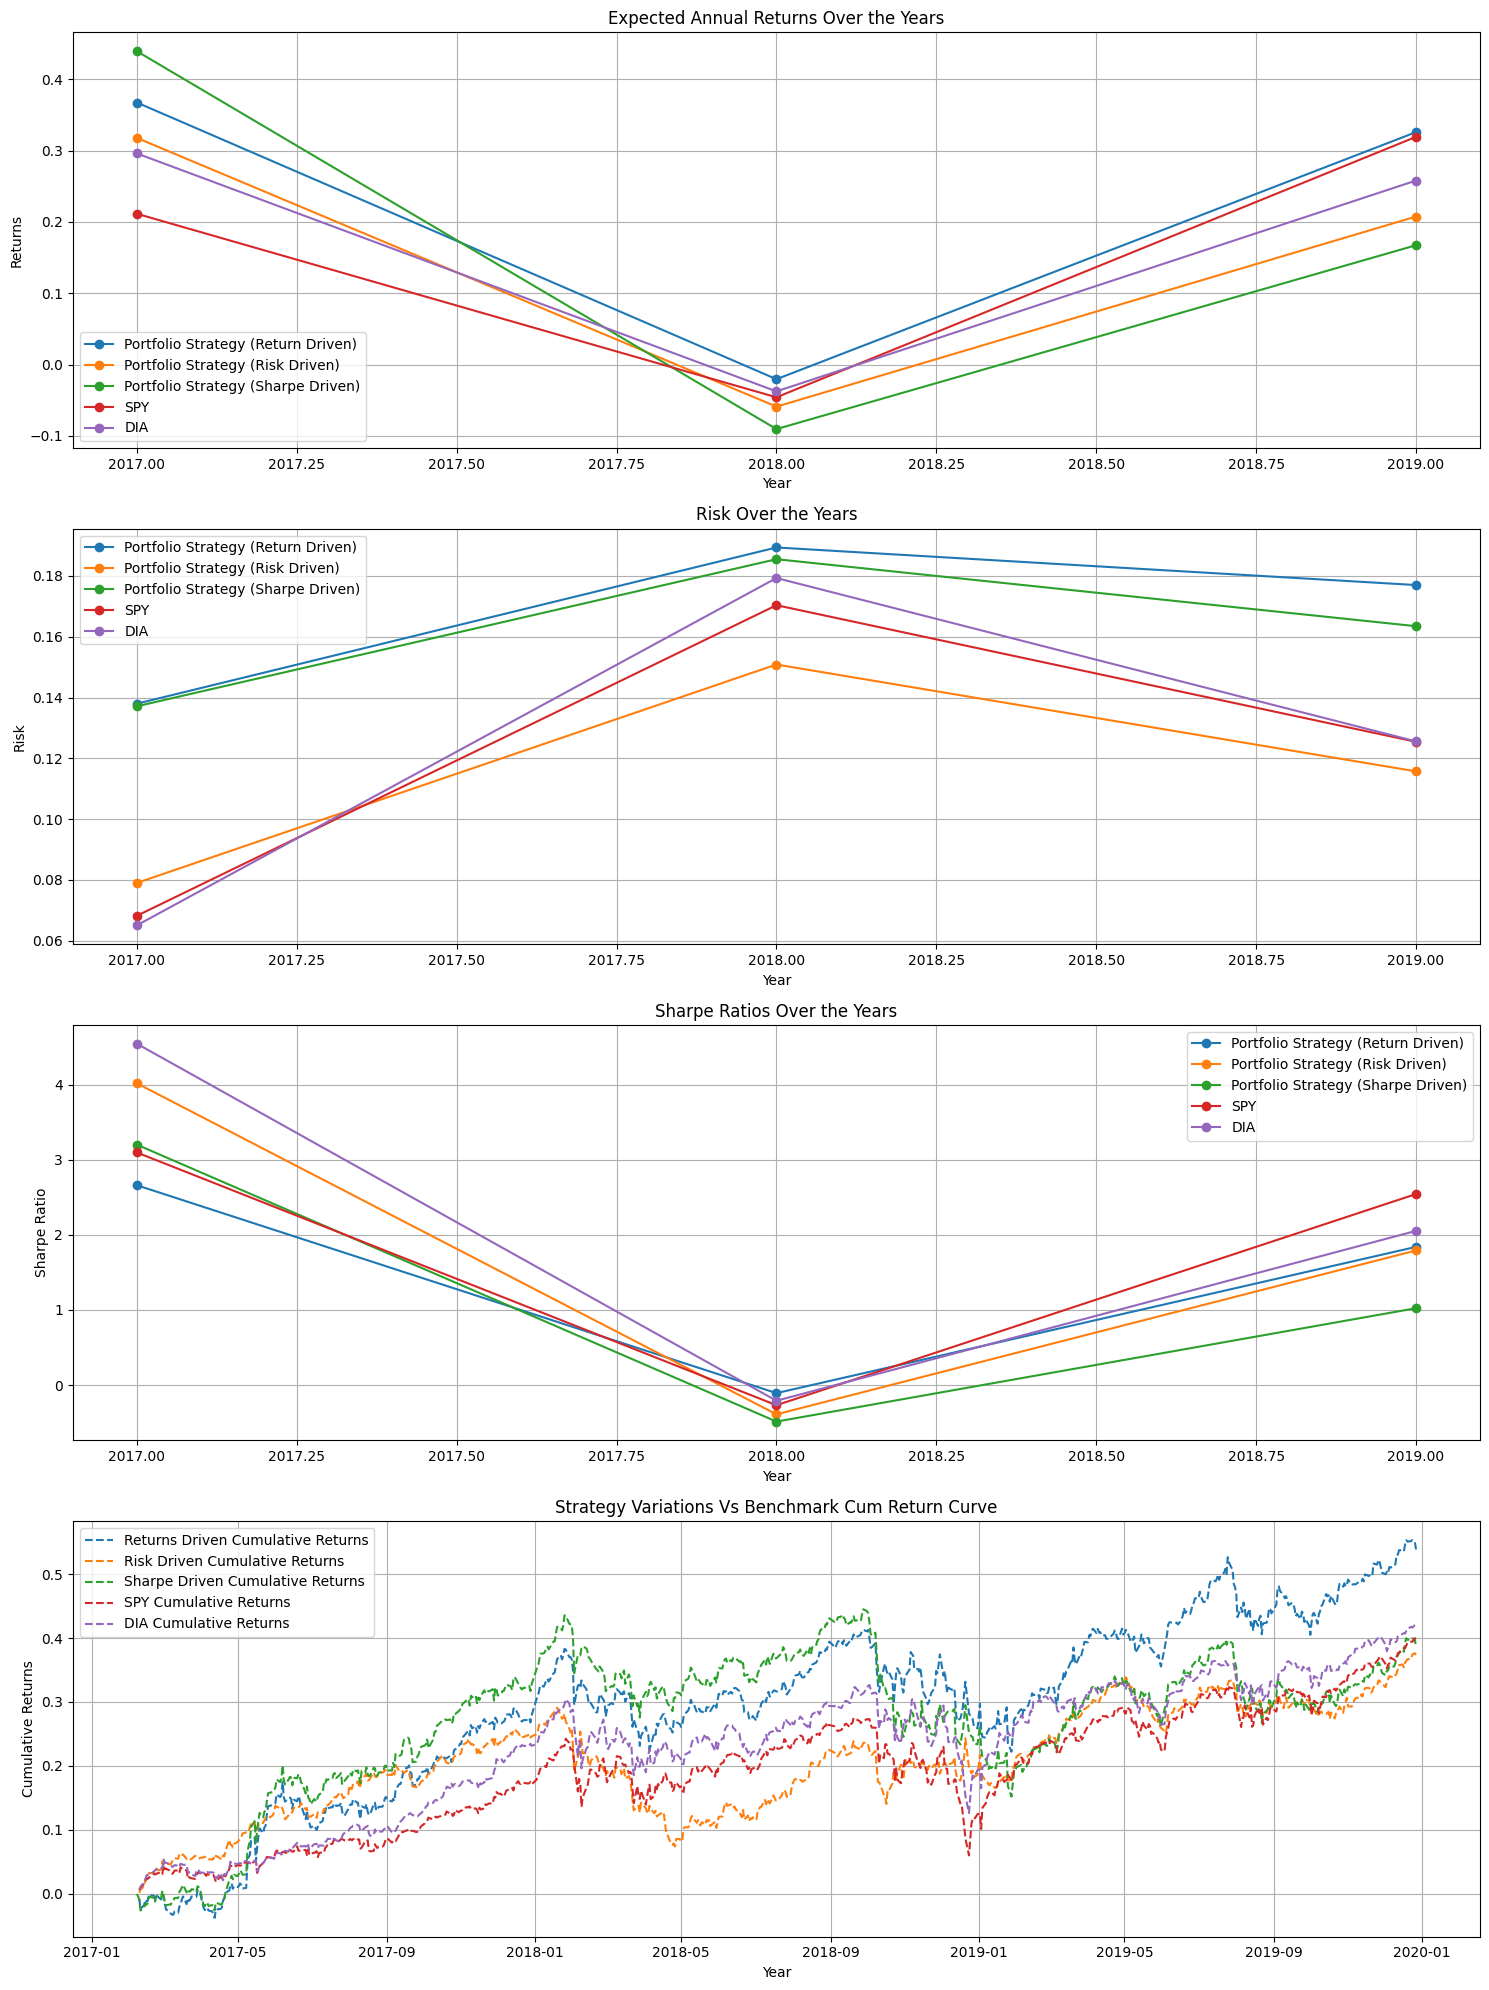

In [26]:
# Metrics Analysis on test data
print("=" * 50)
print("ANALYSIS OF METRICS GENERATED ON TESTING DATA")
test_results_data = test_return_driven.Final_result_data.copy()  # Get the return drive results data from the strategy
test_results_data = test_results_data.merge(dji_returns, left_index=True, right_index=True)  # Add in the DJIA data

# Compute Metrics
test_spy_metrics = calc_metrics(test_results_data, "Returns_SPY")  # Calculate metrics for the benchmark (SPY)
test_dji_metrics = calc_metrics(test_results_data, "Return_DIA")  # Calculate metrics for the benchmark (DJIA)
test_ret_strategy_metrics = calc_metrics(test_results_data, "capital_log_returns")  # Calculate metrics for the strategy on return-driven parameters
test_risk_strategy_metrics = calc_metrics(test_risk_driven.Final_result_data.copy(), "capital_log_returns")  # Calculate metrics for the strategy on risk-driven parameters
test_sharpe_strategy_metrics = calc_metrics(test_sharpe_driven.Final_result_data.copy(), "capital_log_returns")  # Calculate metrics for the strategy on sharpe-driven parameters

# Combine the metrics for the strategy variations, stock portfolio, and benchmark
test_comparison_df = pd.concat(
    [
        test_ret_strategy_metrics,
        test_risk_strategy_metrics,
        test_sharpe_strategy_metrics,
        # stock_portfolio_metrics
        test_spy_metrics,
        test_dji_metrics,
    ], ignore_index=True)

test_comparison_df.index = [
    "Portfolio Strategy (Return Driven)",
    "Portfolio Strategy (Risk Driven)",
    "Portfolio Strategy (Sharpe Driven)",
    "SPY",
    "DIA",
] # Assign meaningful labels to the index

# Display the comparison of portfolio metrics (returns, risk, Sharpe ratio)
display(test_comparison_df)

# Compute yearly statistics (for each year in the dataset)
yearly_test_spy_metrics, test_spy_cumsum = calc_yearly_metrics(test_results_data, "Returns_SPY")  # Yearly metrics for SPY
yearly_test_dji_metrics, test_dji_cumsum = calc_yearly_metrics(test_results_data, "Return_DIA")  # Yearly metrics for DJIA
yearly_test_ret_strategy_metrics, test_ret_strategy_cumsum = calc_yearly_metrics(test_results_data, "capital_log_returns")  # Yearly metrics for the strategy on return-driven parameters
yearly_test_risk_strategy_metrics, test_risk_strategy_cumsum = calc_yearly_metrics(test_risk_driven.Final_result_data.copy(), "capital_log_returns")  # Yearly metrics for the strategy on risk-driven parameters
yearly_test_sharpe_strategy_metrics, test_sharpe_strategy_cumsum = calc_yearly_metrics(test_sharpe_driven.Final_result_data.copy(), "capital_log_returns")  # Yearly metrics for the strategy on sharpe-driven parameters

# Combine the yearly metrics for comparison
test_yearly_comparison_df = pd.concat(
    [
        yearly_test_ret_strategy_metrics, # Yearly metrics for the strategy on return-driven parameters
        yearly_test_risk_strategy_metrics, # Yearly metrics for the strategy on risk-driven parameters
        yearly_test_sharpe_strategy_metrics, # Yearly metrics for the strategy on sharpe-driven parameters
        yearly_test_spy_metrics,  # Yearly metrics for SPY
        yearly_test_dji_metrics,  # Yearly metrics for DIA

    ])

# Combine the cumulative returns for comparison
test_cumsums = pd.DataFrame({
    "Returns Driven Cumulative Returns": test_ret_strategy_cumsum,
    "Risk Driven Cumulative Returns": test_risk_strategy_cumsum,
    "Sharpe Driven Cumulative Returns": test_sharpe_strategy_cumsum,
    "SPY Cumulative Returns": test_spy_cumsum,
    "DIA Cumulative Returns": test_dji_cumsum,
})

# Rename the index for clarity (to make it more readable)
test_yearly_comparison_df.index = ["Portfolio Strategy (Return Driven)"] * 3 + \
    ["Portfolio Strategy (Risk Driven)"] * 3 + \
    ["Portfolio Strategy (Sharpe Driven)"] * 3 + \
    ["SPY"] * 3 + \
    ["DIA"] * 3


# Display the yearly comparison of portfolio metrics
fig2 = viz_metrics_by_year(test_yearly_comparison_df, test_cumsums)  # Call the visualization function to plot the metrics over time

Based on the plots above, the returns-driven approach was able to outperform the other variations, by being able to deliver the highest return on investment of 71.4%, outperforming the benchmark and the risk-driven approach consistently over the majority of the testing period.

As such, we will now zoom in to examine the return-driven variation against the benchmark.

#### Comparison of return-driven variation against benchmark (Testing Period)

Below, we plot the same graphs in relation to the SPY and DIA benchmarks to get a better overview of the performance of the returns-driven approach.

Expected Annual Returns  Annual Risk  \
Portfolio Strategy (Return Driven)                     0.21         0.17   
SPY                                                    0.15         0.13   
DIA                                                    0.16         0.13   

                                    Annual Sharpe Ratio  
Portfolio Strategy (Return Driven)                 1.20  
SPY                                                1.14  
DIA                                                1.18

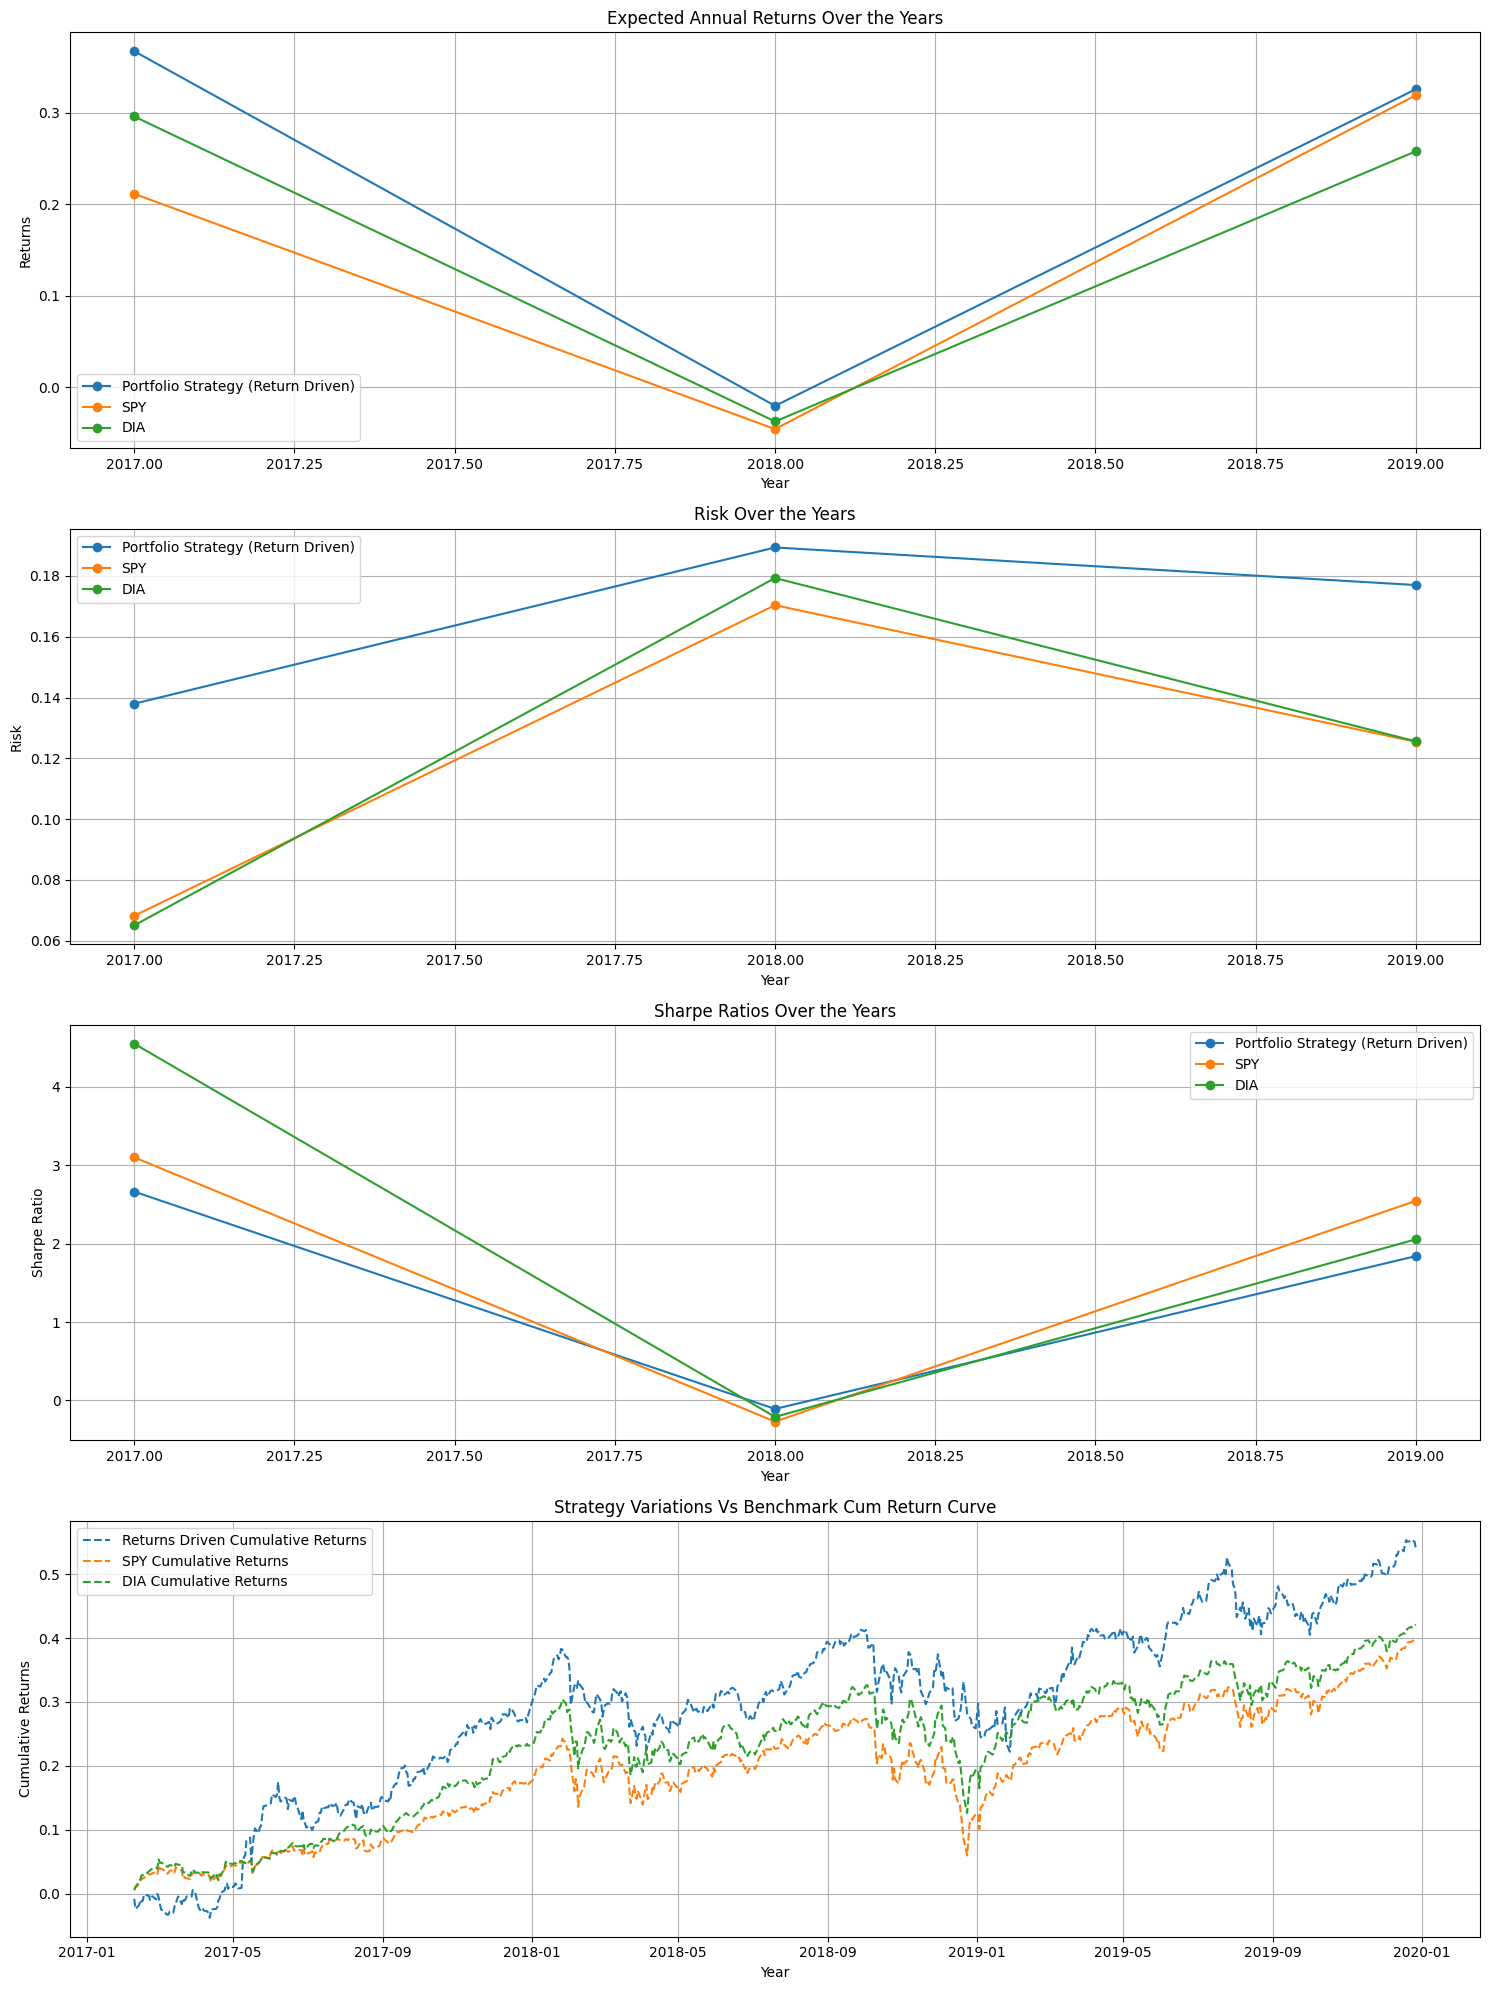

In [27]:
# Keep only return-driven variation and benchmark.
test_ret_vs_benchmarks = pd.concat(
    [
        test_ret_strategy_metrics,
        test_spy_metrics,
        test_dji_metrics,
    ], ignore_index=True)

test_ret_vs_benchmarks.index = [
    "Portfolio Strategy (Return Driven)",
    "SPY",
    "DIA",
] # Update labels

# Display the comparison of portfolio metrics (returns, risk, Sharpe ratio)
display(test_ret_vs_benchmarks)

# Keep metric breakdown by year for return-driven variation and benchmark only.
test_yearly_ret_vs_benchmark = pd.concat(
    [
        yearly_test_ret_strategy_metrics, # Yearly metrics for the strategy on return-driven parameters
        yearly_test_spy_metrics, # Yearly metrics for SPY
        yearly_test_dji_metrics, # Yearly metrics for DJIA
    ])

test_cumsums_ret_bench = pd.DataFrame({
    "Returns Driven Cumulative Returns": test_ret_strategy_cumsum,
    "SPY Cumulative Returns": test_spy_cumsum,
    "DIA Cumulative Returns": test_dji_cumsum,
})

# Rename the index for clarity (to make it more readable)
test_yearly_ret_vs_benchmark.index = ["Portfolio Strategy (Return Driven)"] * 3 + \
    ["SPY"] * 3 + \
    ["DIA"] * 3

# Display the yearly comparison of portfolio metrics
fig2 = viz_metrics_by_year(test_yearly_ret_vs_benchmark, test_cumsums_ret_bench)  # Call the visualization function to plot the metrics over time

### Testing Period Summary

Based on these comparisons, it is clear that the return-driven strategy stands out as the strongest performer,the only strategy to consistently outperform both benchmarks across the expected returns and Sharpe Ratio. This optimised approach not only achieves the highest returns but also demonstrates resilience in delivering a superior risk-adjusted return above that of both SPY and DIA.

## **Backtest Summary**
---
The return-driven approach presents the overall best-protection to downside risk while being able to outperforms the other approaches and benchmarks in terms of returns and annual sharpe ratio, showing exemplary performance and strong potential for investors seeking both growth and risk efficiency.
